# Laborator 11 - Clasificare de tip text

## Nume studenti:
- Alexandra Manole
- Teodor Mihaescu

## Grupa: 382

Folosind un set de date - de exemplu de la https://archive.ics.uci.edu/ml/datasets.php?format=&task=&att=&area=&numAtt=&numIns=&type=text&sort=nameUp&view=table - sa se rezolve o problema de clasificare sau regresie, plecand de la intrari de tip text.

Se poate opta pentru codificare BOW, n-grams, word2vec sau altele adecvate. Modelele de predictie pot fi din biblioteca scikit-learn. Puteti folosi pentru preprocesare biblioteca [NLTK](https://www.nltk.org) etc.

Pentru clasificare se va optimiza scorul F1; se vor raporta scorurile F1 si acuratetea. Pentru regresie se va optimiza scorul mean squared error; se vor raporta scorurile MSE, mean absolute error, r2.

Exemple:
1. [Clasificare de SMS-uri](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)
1. [Sentence Classification Data Set](https://archive.ics.uci.edu/ml/datasets/Sentence+Classification#)
1. [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)
1. [Victorian Era Authorship Attribution Data Set](https://archive.ics.uci.edu/ml/datasets/Victorian+Era+Authorship+Attribution)
1. [Amazon Commerce reviews set Data Set](https://archive.ics.uci.edu/ml/datasets/Amazon+Commerce+reviews+set)
1. [Farm Ads Data Set](https://archive.ics.uci.edu/ml/datasets/Farm+Ads)
1. etc...


Se vor investiga minim 2 seturi de date si pentru fiecare din ele minim 4 modele de clasificare sau regresie. Daca setul de date e deja impartit in train si test, se va folosi ca atare - setul de antrenare se va imparti, suplimentar in train + validation; altfel, se va face kfold CV, k=5. Valorile optimale ale hiperparametrilor vor fi alesi prin random search si grid search.

Pentru fiecare set de date:
1. (2 x 0.5 p) Se descrie setul de date, in limba romana (continut, provenienta, problema etc.)
1. (2 x 1 p) Se face analiza exploratorie, folosind cod Python: distributia claselor sau a valorilor continue de iesire - numeric si grafic, statistici asupra textelor (de exemplu: lungime minima/medie/maxima; cele mai frecvente k cuvinte; clustering etc.). Se va explica fiecare pas si ce se urmareste prin efectuarea lui. Graficele vor avea axele numite (ce se reprezinta, evetual unitate de masura)
1. (2 x 0.5 p) Se face preprocesare de date; se explica in limba romana care sunt metodele de preprocesare folosite, efectul lor pe datele de intrare, ce forma are iesirea obtinuta; se arata efectele pasilor de preprocesare asupra setului de date (noul numar de documente, dinamica vocabularului, trasaturile rezultate etc.) Se pot aduga grafice si tabele la acest pas.
1. (2 x 4 x 0.5 p) Clasificare sau regresie, dupa caz: se face o descriere a modelelor considerate, in limba romana; se descrie modalitatea de cautare a hiperparametrilor; rezultatele obtinute se vor prezenta tabelar, similar cu tema precedenta. 

Se acorda doua puncte din oficiu.

Descrierea modelelor si a pasilor de preprocesare pot fi in sectiuni separate, cu referinte la acestea unde e necesar. Partea specifica aplicarii pasilor pe datele considerate va fi prezentata respectand ordinea de aplicare. 

Exemple:
1. [Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
1. [Text Classification with Python and Scikit-Learn](https://stackabuse.com/text-classification-with-python-and-scikit-learn/)
1. [How to Prepare Text Data for Machine Learning with scikit-learn](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

In [1]:
import numpy as np
from numpy.random import default_rng
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_files
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_letters, digits, punctuation
from textblob import TextBlob
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
pd.set_option('max_colwidth', 500)
le = preprocessing.LabelEncoder()
sns.set_palette("deep")
np.set_printoptions(edgeitems=17)
tfidf = TfidfVectorizer(analyzer='word')
bow = CountVectorizer(analyzer = "word")
rng = default_rng()

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: red' if v else '' for v in is_max]

def highlight_min(s):
    is_max = s == s.min()
    return ['background-color: green' if v else '' for v in is_max]

## Seturi de date alese

### [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

In [3]:
sms_df = pd.read_csv('./data/smsspamcollection/SMSSpamCollection', sep='\t', names=['class', 'message'])
sms_df = sms_df.reindex(columns=['message', 'class'])
sms_df.loc[:, 'class'] = le.fit_transform(sms_df.loc[:, 'class'])
sms_df.head(10)

,message,class
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives around here though",0
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",1
6,Even my brother is not like to speak with me. They treat me like aids patent.,0
7,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,0
8,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,1
9,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1


In [4]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'ham': 0, 'spam': 1}

### [Victorian Era Authorship Attribution Data Set](https://archive.ics.uci.edu/ml/datasets/Victorian+Era+Authorship+Attribution)

In [5]:
victorian_df = pd.read_csv('./data/dataset/Gungor_2018_VictorianAuthorAttribution_data-train.csv', sep=',', 
                           names=['text', 'author'], encoding='ISO-8859-1')
victorian_df.head(10)

,text,author
0,ou have time to listen i will give you the entire story he said it may form the basis of a future novel and prove quite as interesting as one of your own invention i had the time to listen of course one has time for anything and everything agreeable in the best place to hear the tale was in a victoria and with my good on the box with the coachman we set out at once on a drive to the as the recital was only half through when we reached the house we postponed the remainder while we stopped the...,1
1,wish for solitude he was twenty years of age and in the possession of perfect health most youths like him would have the stillness of the and welcomed joyfully the first signs of that awakening that would come with the sunrise was sentimental the strangeness of the situation gave him a real delight he lay back in the comfortable seat stretched his legs and gave himself up to reverie his brain dwelt on the poetic quality of this peculiar place its history of which he had read much passed slow...,1
2,and the skirt blew in perfect freedom about the upper parts she wore no hat and her hair hung in a careless to the level of her waist the girl returned s interested look finding him quite as well worth noting as he found her and they were apparently trying to decide which should the other when a short crisp word from the master of her boat called her attention to her work with a farewell glance that expressed regret as plainly as any formed sentence the child bent her young energies with str...,1
3,of san and the rows of shops opposite impressed themselves upon his vision then the and last of all young mr gray a h h he said again he reached his hand toward a pocket of his and finding neither watch nor chain there he said love gone astray ah for the third time and began to get upon his feet what time is it he asked yawning and gray delighted that the conversation had thus begun responded that it was between seven and eight o clock the man spoke english and was apparently a native of the...,1
4,an hour s walk was as tiresome as three in a sensible english town v but the skies remarked gray with enthusiasm love gone astray have you ever seen such beauty in the of sea and air as there is at sunset i thought before i came here that the painters had drawn on their but they do not half the reality and in the evening when the singing parties go out on the water what a soul stirring effect they produce i had rather hear one of these of accompanied by their and than the best opera in one o...,1
5,on the comfortable seat the last thing had seen was the beautiful city under the deep blue of a sky lit by the stars alone the broken moon having gone to rest below the horizon when the beauty of morning came again he experienced anew the pleasure of finding asleep and witnessing her awakening a little earlier than on the previous day he dismissed his and went to s for his coffee something to his surprise he found his english friend already there of as substantial a meal as the house could f...,1
6,on account of his health which is very bad he s at now and i ve run over here alone for a few days because the doctors don t think it best for him to come to the shore he s quite a different man from the one you speak of he counts all his i assure vou and he s made a handsome pile doing it i don t think he d at all approve of my forty dollars to a stranger but what s mine s my own as the saying is from that went on in the open way that was a part of his nature to talk about his affairs he ha...,1
7,at any rate whatever took place was for the mutual pleasure and satisfaction of all concerned and there is no reason to find fault with it at this late date with the horrors he had dreamed of still ringing in his head mr gray demanded an explanation of these why said the so called were whose death was decided upon in some form they had been guilty usually of making war against a superior force and according to the old custom would have been without merc

## Se descrie setul de date, in limba romana (continut, provenienta, problema etc.)

### [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

#### Continut

Setul de date este compus dintr-un singur fisier .txt, unde fiecare linie are pe prima componenta $clasa$ corespunzatoare, urmata de $mesajul$ brut. Mesajele nu sunt sortate cronologic.

Un sample extras random este:

    1. ham What you doing?how are you?

    2. ham Ok lar... Joking wif u oni...

    3. ham dun say so early hor... U c already then say...

    4. spam MY NO.1 WINNER IN LUTON +0125698789 RING ME IF UR AROUND WIN WIN WIN! H*

    5. ham Siva is in hostel aha:-.

#### Provenienta

Acest set a fost colectat din surse free sau surse free destinate dezvoltarii, aflate pe internet. O serie de mesaje spam au fost extrase manual de pe site-ul Grumbletext Web. Acesta este un forum englezesc in care utilizatorii isi expun propriile mesaje de tip spam. De asemenea, o mare parte din mesaje provin din Singapore, mai exact de la studenti. Aceste mesaje au fost colectate de voluntari, care au fost informati in legatura cu distributia datelor cu caracter personal.

#### Problema

Setul de date "SMS Spam Collection" este un set public de mesaje adnotate, care a fost conceput pentru a dezvolta protectia antispam a telefoanelor mobile. Identificarea textelor cu caracter de spam este o sarcina costisitoare din punct de vedere timp si una extrem de dificila pentru omul de rand, astfel s-a dorit efectuarea unui ML pentru rezolvarea acestei probleme.

### [Victorian Era Authorship Attribution Data Set](https://archive.ics.uci.edu/ml/datasets/Victorian+Era+Authorship+Attribution)

#### Continut

Fiecare instanta a setului de date "Victorian Era Authorship Attribution" este alcatuita din 1000 de cuvinte care sunt clasificate in functie de 50 de autori. De retinut, in setul de date se regasesc doar id-urile autorilor cu numere de la 1 la 50, numele intregi ale acestora, regasindu-se in link-ul de mai sus. Continutul instantelor este impartit in $text$ si $autor$.

Un exemplu:

    and the skirt blew in perfect freedom about the upper parts she wore no hat and her hair hung in a careless to the level of her waist the girl returned s interested look finding him quite as well worth noting as he found her and they were apparently trying to decide which should the other when a short crisp word from the master of her boat called her attention to her work with a farewell glance that expressed regret as plainly as any formed sentence the child bent her young energies with strength ... flying from above lit on the rim of the soft hat and came with a great flapping of wings into his very face that the turned and made an involuntary motion to brush away the the removal of the protecting arm allowed the sunlight to fall upon his eyelids and the awakening that had taken so long was accomplished a h h he muttered rousing himself into a sitting posture and stretching his stiff limbs after making which remark he sat up and with his back against the column of st mark looked around the palace of the the church ,4

#### Provenienta

Textele au fost extrase din baza de date "GDELT". Proiectul cu acelasi nume este o platforma open-source pentru dezvoltarea si analiza societatii la nivel global si astfel, toate seturile de date din acest proiect sunt valabile pe perioada nedeterminata pentru uzul academic, comercial sau guvernamental, fara a fi supusi unor costuri de achizitionare.

#### Problema

Problema pusa este de a realiza cel mai mare set de date cu lucrari cunoscute din perioada victoriana si de a reusi un model prin care se definesc si gasesc stilurile si lucrarile celor 50 de autori celebri din acea perioada.

## Se face analiza exploratorie, folosind cod Python: distributia claselor sau a valorilor continue de iesire - numeric si grafic, statistici asupra textelor (de exemplu: lungime minima/medie/maxima; cele mai frecvente k cuvinte; clustering etc.). Se va explica fiecare pas si ce se urmareste prin efectuarea lui. Graficele vor avea axele numite (ce se reprezinta, evetual unitate de masura)

In [6]:
def avg_word(sentence):
    words = sentence.split()
    return np.round((sum(len(word) for word in words) / len(words)), 2)

stopwrd = stopwords.words('english')

with open('./data/stopwords.txt', 'r', encoding="utf8") as file:
    large_stopwrd = file.readlines()    
large_stopwrd = [x.strip('\n') for x in large_stopwrd]

stopwrd.extend(x for x in large_stopwrd if x not in stopwrd)

# am extins lista la 876 de cuvinte

### SMS Spam Collection Data Set

In [7]:
# din cauza faptului ca setul de date este extrem de biased pe mesajele non spam
# am decis sa realizam o echilibrare a setului
# pasii nu sunt afectati de aceasta schimbare

to_remove = np.random.choice(sms_df[sms_df['class'] == 0].index, size=4000, replace=False)
sms_df.drop(to_remove, inplace=True)
sms_df.reset_index(drop=True, inplace=True)

drop_inst = rng.choice(1572, size = 572, replace=False)
sms_df.drop(drop_inst, inplace=True)
sms_df.reset_index(drop=True, inplace=True)

In [8]:
print(f'Total instances: {sms_df.count().tolist()}')

# nu se remarca missing values, astfel nu este nevoie de
# pasul de missing value imputation

Total instances: [1000, 1000]


In [9]:
classes = np.unique(sms_df.loc[:, 'class']).tolist()
print(f'Unique classes: {le_name_mapping}')

Unique classes: {'ham': 0, 'spam': 1}


#### Distributia claselor: grafic si numeric

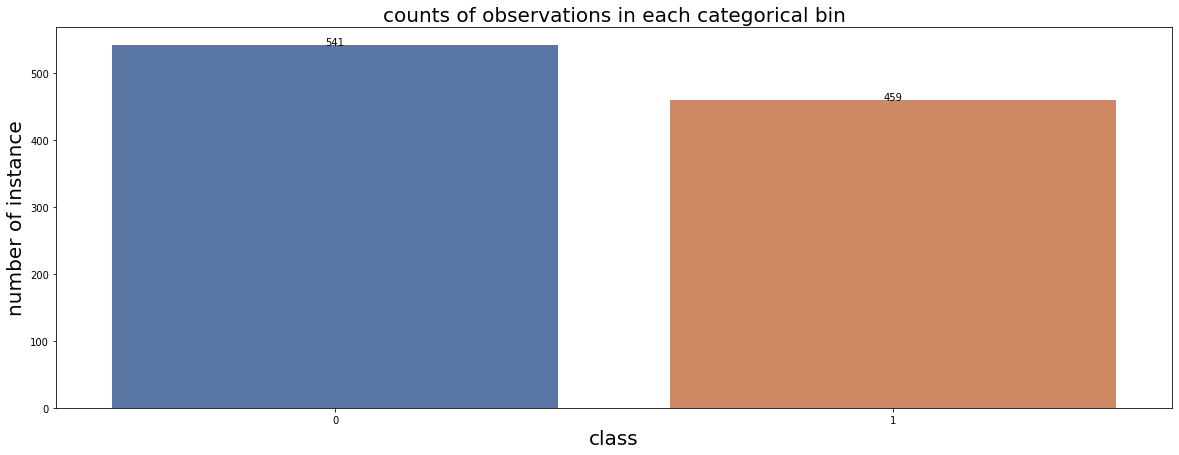

In [10]:
fig, ax = plt.subplots(figsize=(20, 7))
graph = sns.countplot(sms_df.loc[:, 'class'])
ax.set_xlabel('class', size=20)
ax.set_ylabel('number of instance', size=20)
for bins in graph.patches:
    height = bins.get_height()
    graph.text(bins.get_x() + bins.get_width() / 2, height, height, ha="center")
plt.title('counts of observations in each categorical bin', size=20)
plt.show()

# am realizat acest plot pentru a putea vizualiza
# impartirea numerica a variabilelor unui atribut

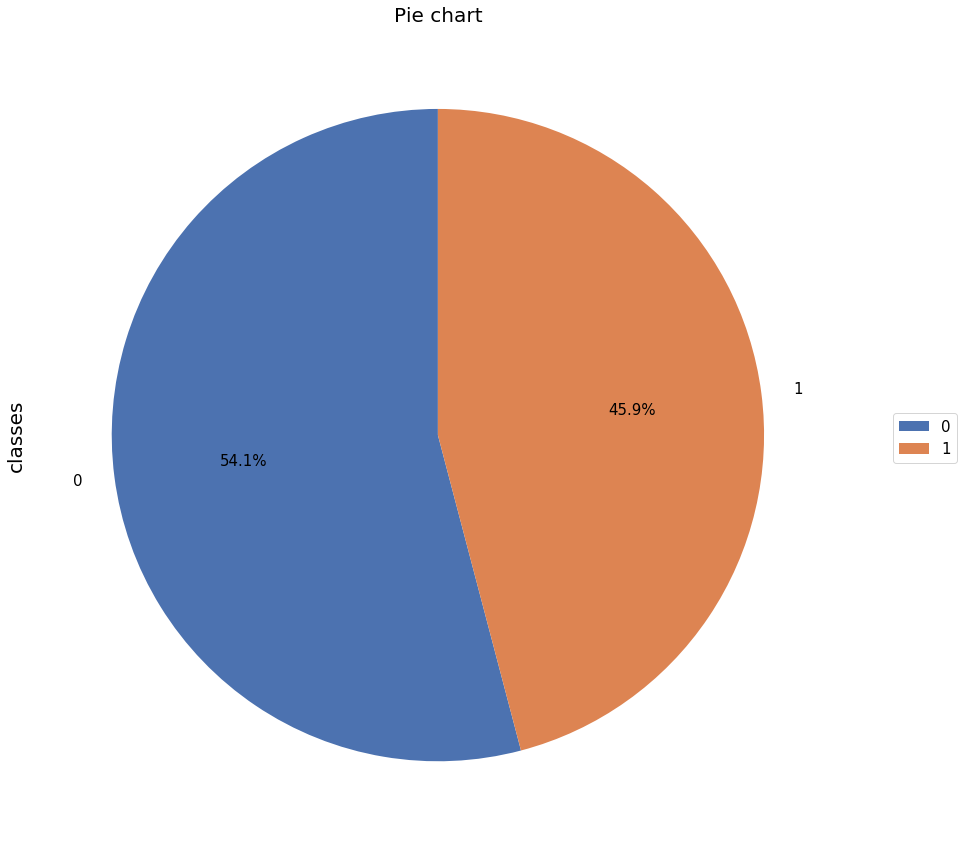

In [11]:
pd.DataFrame(sms_df['class']).apply(pd.value_counts).plot(kind='pie', figsize=(15, 15), subplots=True, autopct='%1.1f%%', 
                                                          shadow = False, startangle = 90, fontsize = 15)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center right", fontsize=15, bbox_transform=plt.gcf().transFigure)
plt.ylabel('classes', size=20)
plt.title(f'Pie chart', size=20)
plt.show()

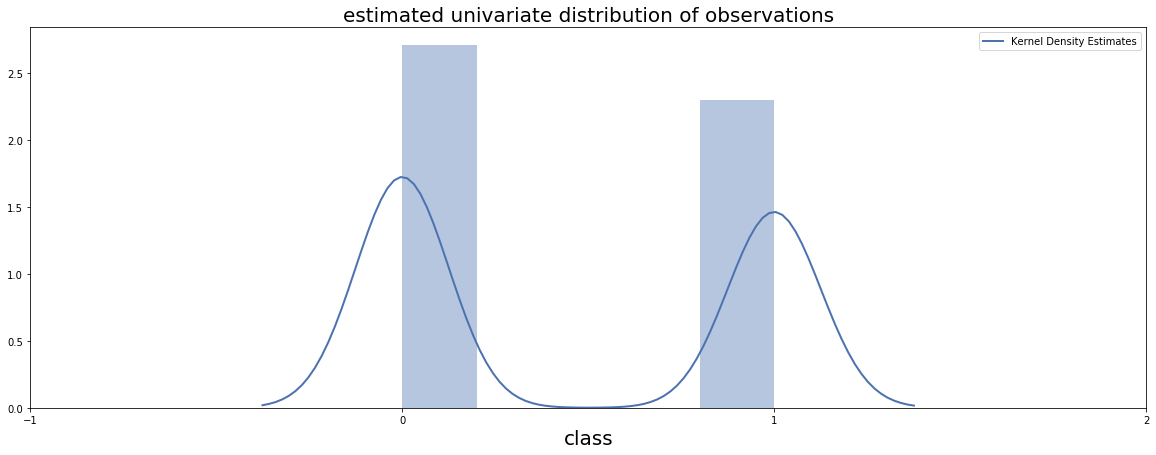

In [12]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.distplot(sms_df.loc[:, 'class'], ax=ax,
             kde_kws={"lw": 2, "label": "Kernel Density Estimates"})
ax.set_xlim(-1, 2)
ax.set_xticks(range(-1, 3))
ax.set_xlabel('class', size=20)
plt.title('estimated univariate distribution of observations', size=20)
plt.show()

# am realizat acest plot pentru a putea vizualiza
# cum sunt distribuite variabilele unui anumit atribut

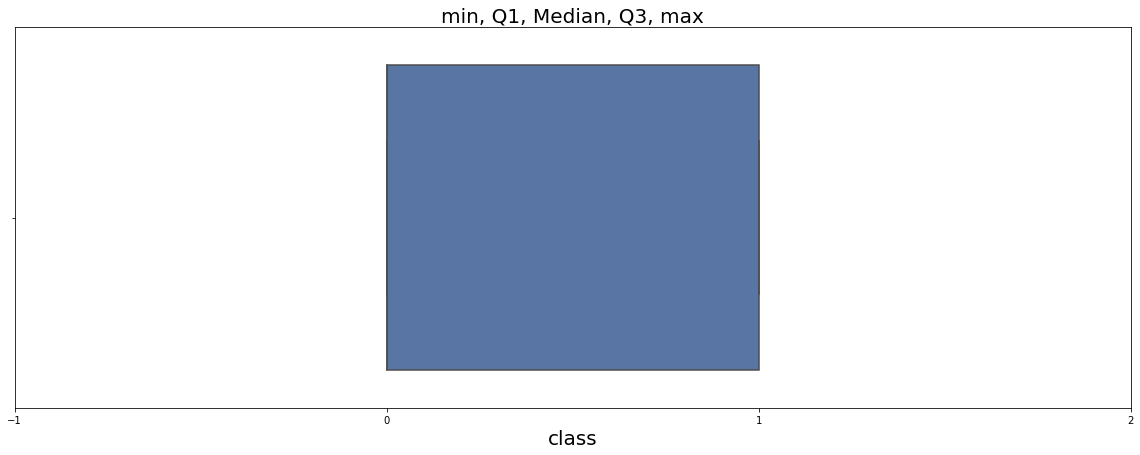

In [13]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(sms_df.loc[:, 'class'])
ax.set_xlim(-1, 2)
ax.set_xticks(range(-1, 3))
ax.set_xlabel('class', size=20)
plt.title('min, Q1, Median, Q3, max', size=20)
plt.show()

# am realizat acest plot pentru a putea vizualiza
# distributia valorilor pe quantilele 1, 2, 3
# eliminarea automata a outlayere-lor

#### Statistici asupra textelor

In [14]:
stats_sms_df = sms_df.copy()

In [15]:
stats_sms_df.loc[:, 'word_count'] = stats_sms_df.loc[:, 'message'].apply(lambda x: len(str(x).split(' ')))
stats_sms_df.loc[:, ['message','word_count']].head(10)

# extragerea numarului de cuvinte din fiecare mesaj

,message,word_count
0,Ok lar... Joking wif u oni...,6
1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,28
2,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,26
3,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,29
4,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",26
5,I HAVE A DATE ON SUNDAY WITH WILL!!,8
6,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL",19
7,Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?,20
8,Did you catch the bus ? Are you frying an egg ? Did you make a tea? Are you eating your mom's left over dinner ? Do you feel my Love ?,32
9,"Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us",26


In [16]:
stats_sms_df.loc[:, 'char_count'] = stats_sms_df.loc[:, 'message'].str.len() - stats_sms_df.loc[:, 'message'].str.count(' ')
stats_sms_df.loc[:, ['message', 'char_count']].head(10)

# extragerea numarului de caractere, fara spatii luate in considerare

,message,char_count
0,Ok lar... Joking wif u oni...,24
1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,128
2,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,132
3,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,126
4,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",111
5,I HAVE A DATE ON SUNDAY WITH WILL!!,28
6,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL",131
7,Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?,69
8,Did you catch the bus ? Are you frying an egg ? Did you make a tea? Are you eating your mom's left over dinner ? Do you feel my Love ?,103
9,"Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us",105


In [17]:
stats_sms_df.loc[:, 'avg_word_len'] = stats_sms_df.loc[:, 'message'].apply(lambda x: avg_word(x))
stats_sms_df.loc[:, ['message', 'avg_word_len']].head(10)

# determinarea lungimii medii a unui cuvant

,message,avg_word_len
0,Ok lar... Joking wif u oni...,4.00
1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,4.57
2,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,5.08
3,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,4.34
4,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",4.27
5,I HAVE A DATE ON SUNDAY WITH WILL!!,3.50
6,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL",6.89
7,Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?,3.45
8,Did you catch the bus ? Are you frying an egg ? Did you make a tea? Are you eating your mom's left over dinner ? Do you feel my Love ?,3.22
9,"Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us",4.04


In [18]:
stats_sms_df.loc[:, 'stopwords'] = stats_sms_df.loc[:, 'message'].apply(lambda x: [x for x in x.split() if x in stopwrd])
stats_sms_df.loc[:, 'stopwords_count'] = stats_sms_df.loc[:, 'message'].apply(lambda x: len([x for x in x.split() if x in stopwrd]))
stats_sms_df.loc[:, ['message', 'stopwords', 'stopwords_count']].head(10)

# determinarea (numarului de) english-stopwords

,message,stopwords,stopwords_count
0,Ok lar... Joking wif u oni...,[u],1
1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,"[in, a, to, to, to]",5
2,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,"[a, you, have, been, to, call]",6
3,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,"[your, or, to, to, the, with, for, on]",8
4,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info","[to, to, and, to]",4
5,I HAVE A DATE ON SUNDAY WITH WILL!!,[I],1
6,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL","[use, your, the, in, the, next, or]",7
7,Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?,"[i, my, then, i, go, down]",6
8,Did you catch the bus ? Are you frying an egg ? Did you make a tea? Are you eating your mom's left over dinner ? Do you feel my Love ?,"[you, the, you, an, you, make, a, you, your, over, you, my]",12
9,"Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us","[that's, still, not, all, that, were, you, not, sure, about, me, being, or, that, that's, why, x, doesn't, want, to, with, us]",22


In [19]:
stats_sms_df.loc[:, 'special_characters'] = stats_sms_df.loc[:, 'message'].apply(lambda x: [x for x in x.split() if set(x).difference(ascii_letters + digits)])
stats_sms_df.loc[:, 'special_characters_count'] = stats_sms_df.loc[:, 'message'].apply(lambda x: len([x for x in x.split() if set(x).difference(ascii_letters + digits)]))
stats_sms_df.loc[:, ['message', 'special_characters', 'special_characters_count']].head(10)

# determinarea (numarului de) cuvinte care contin caractere speciale

,message,special_characters,special_characters_count
0,Ok lar... Joking wif u oni...,"[lar..., oni...]",2
1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,"[2005., question(std, rate)T&C's, 08452810075over18's]",4
2,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,"[WINNER!!, £900, reward!, 09061701461., KL341., only.]",6
3,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,"[more?, Free!]",2
4,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info","[CASH!, 20,000, txt>, 87575., 150p/day,, 6days,, 16+]",7
5,I HAVE A DATE ON SUNDAY WITH WILL!!,[WILL!!],1
6,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL","[XXXMobileMovieClub:, credit,, here>>, http://wap., xxxmobilemovieclub.com?n=QJKGIGHJJGCBL]",5
7,Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?,"[lor., lor., already?]",3
8,Did you catch the bus ? Are you frying an egg ? Did you make a tea? Are you eating your mom's left over dinner ? Do you feel my Love ?,"[?, ?, tea?, mom's, ?, ?]",6
9,"Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us","[that's, clear,, that's, doesn't]",4


In [20]:
stats_sms_df.loc[:, 'numerics'] = stats_sms_df.loc[:, 'message'].apply(lambda x: [x for x in x.split() if x.isdigit()])
stats_sms_df.loc[:, 'numerics_count'] = stats_sms_df.loc[:, 'message'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
stats_sms_df.loc[:, ['message', 'numerics', 'numerics_count']].head(10)

# determinarea exclusiva a numerelor si contorizarea lor

,message,numerics,numerics_count
0,Ok lar... Joking wif u oni...,[],0
1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,"[2, 87121]",2
2,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,[12],1
3,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,"[11, 08002986030]",2
4,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info","[100, 4]",2
5,I HAVE A DATE ON SUNDAY WITH WILL!!,[],0
6,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL",[],0
7,Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?,[3],1
8,Did you catch the bus ? Are you frying an egg ? Did you make a tea? Are you eating your mom's left over dinner ? Do you feel my Love ?,[],0
9,"Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us",[],0


In [21]:
stats_sms_df.loc[:, 'uppercase_words'] = stats_sms_df.loc[:, 'message'].apply(lambda x: [x for x in x.split() if x.isupper()])
stats_sms_df.loc[:, 'uppercase_words_count'] = stats_sms_df.loc[:, 'message'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
stats_sms_df.loc[:, ['message', 'uppercase_words', 'uppercase_words_count']].head(10)

# determinarea si numararea cuvintelor care incep cu majuscula

,message,uppercase_words,uppercase_words_count
0,Ok lar... Joking wif u oni...,[],0
1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,"[FA, FA]",2
2,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,"[WINNER!!, KL341.]",2
3,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,"[U, R, FREE]",3
4,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info","[SIX, CASH!, CSH11, HL]",4
5,I HAVE A DATE ON SUNDAY WITH WILL!!,"[I, HAVE, A, DATE, ON, SUNDAY, WITH, WILL!!]",8
6,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL",[WAP],1
7,Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?,[U],1
8,Did you catch the bus ? Are you frying an egg ? Did you make a tea? Are you eating your mom's left over dinner ? Do you feel my Love ?,[],0
9,"Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us",[],0


In [22]:
stats_sms_df.mask(stats_sms_df.applymap(str).eq('[]'), inplace=True)
stats_sms_df.fillna(value='-', inplace=True)
stats_sms_df.insert(len(stats_sms_df.columns) - 1, 'class', stats_sms_df.pop('class'))
stats_sms_df.head(10)

# inlocuire liste vide cu caracterul "-" si mutarea coloanei "class" pe ultima pozitie

,message,word_count,char_count,avg_word_len,stopwords,stopwords_count,special_characters,special_characters_count,numerics,numerics_count,uppercase_words,uppercase_words_count,class
0,Ok lar... Joking wif u oni...,6,24,4.00,[u],1,"[lar..., oni...]",2,-,0,-,0,0
1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,28,128,4.57,"[in, a, to, to, to]",5,"[2005., question(std, rate)T&C's, 08452810075over18's]",4,"[2, 87121]",2,"[FA, FA]",2,1
2,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,26,132,5.08,"[a, you, have, been, to, call]",6,"[WINNER!!, £900, reward!, 09061701461., KL341., only.]",6,[12],1,"[WINNER!!, KL341.]",2,1
3,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,29,126,4.34,"[your, or, to, to, the, with, for, on]",8,"[more?, Free!]",2,"[11, 08002986030]",2,"[U, R, FREE]",3,1
4,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",26,111,4.27,"[to, to, and, to]",4,"[CASH!, 20,000, txt>, 87575., 150p/day,, 6days,, 16+]",7,"[100, 4]",2,"[SIX, CASH!, CSH11, HL]",4,1
5,I HAVE A DATE ON SUNDAY WITH WILL!!,8,28,3.50,[I],1,[WILL!!],1,-,0,"[I, HAVE, A, DATE, ON, SUNDAY, WITH, WILL!!]",8,0
6,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL",19,131,6.89,"[use, your, the, in, the, next, or]",7,"[XXXMobileMovieClub:, credit,, here>>, http://wap., xxxmobilemovieclub.com?n=QJKGIGHJJGCBL]",5,-,0,[WAP],1,1
7,Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?,20,69,3.45,"[i, my, then, i, go, down]",6,"[lor., lor., already?]",3,[3],1,[U],1,0
8,Did you catch the bus ? Are you frying an egg ? Did you make a tea? Are you eating your mom's left over dinner ? Do you feel my Love ?,32,103,3.22,"[you, the, you, an, you, make, a, you, your, over, you, my]",12,"[?, ?, tea?, mom's, ?, ?]",6,-,0,-,0,0
9,"Wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us",26,105,4.04,"[that's, still, not, all, that, were, you, not, sure, about, me, being, or, that, that's, why, x, doesn't, want, to, with, us]",22,"[that's, clear,, that's, doesn't]",4,-,0,-,0,0


### Victorian Era Authorship Attribution Data Set

In [23]:
# din cauza faptului ca setul de date este extrem de biased pe autorul 8
# am decis sa realizam o echilibrare a setului
# pasii nu sunt afectati de aceasta schimbare

to_remove = np.random.choice(victorian_df[victorian_df['author'] == 8].index, size=4000, replace=False)
victorian_df.drop(to_remove, inplace=True)
victorian_df.reset_index(drop=True, inplace=True)

In [24]:
# din cauza faptului ca setul de date este extrem de biased pe autorul 26
# am decis sa realizam o echilibrare a setului
# pasii nu sunt afectati de aceasta schimbare

to_remove = np.random.choice(victorian_df[victorian_df['author'] == 26].index, size=2000, replace=False)
victorian_df.drop(to_remove, inplace=True)
victorian_df.reset_index(drop=True, inplace=True)

In [25]:
# din cauza faptului ca setul este foarte mare 47678 cu 1000 de cuvinte fiecare
# am decis sa ne rezumam la un numar mai mic de instante
# deoarece timpul de preprocesare si de antrenare sunt mult mai mici
# iar pasii nu sunt afectati de aceasta schimbare

drop_inst = rng.choice(47678, size = 46678, replace=False)
victorian_df.drop(drop_inst, inplace=True)
victorian_df.reset_index(drop=True, inplace=True)

In [26]:
print(f'Total instances: {victorian_df.count().tolist()}')

# nu se remarca missing values, astfel nu este nevoie de
# pasul de missing value imputation

Total instances: [1000, 1000]


In [27]:
classes = np.unique(victorian_df.loc[:, 'author']).tolist()
print(f'Unique classes: {classes}')

Unique classes: [1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 50]


#### Distributia claselor: grafic si numeric

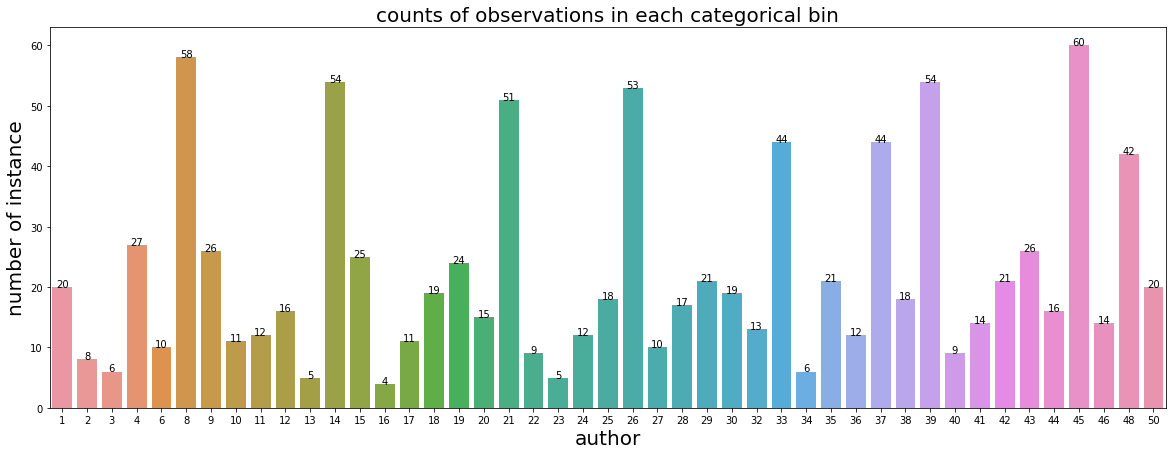

In [28]:
fig, ax = plt.subplots(figsize=(20, 7))
graph = sns.countplot(victorian_df.loc[:, 'author'])
ax.set_xlabel('author', size=20)
ax.set_ylabel('number of instance', size=20)
for bins in graph.patches:
    height = bins.get_height()
    graph.text(bins.get_x() + bins.get_width() / 2, height, height, ha="center")
plt.title('counts of observations in each categorical bin', size=20)
plt.show()

# am realizat acest plot pentru a putea vizualiza
# impartirea numerica a variabilelor unui atribut

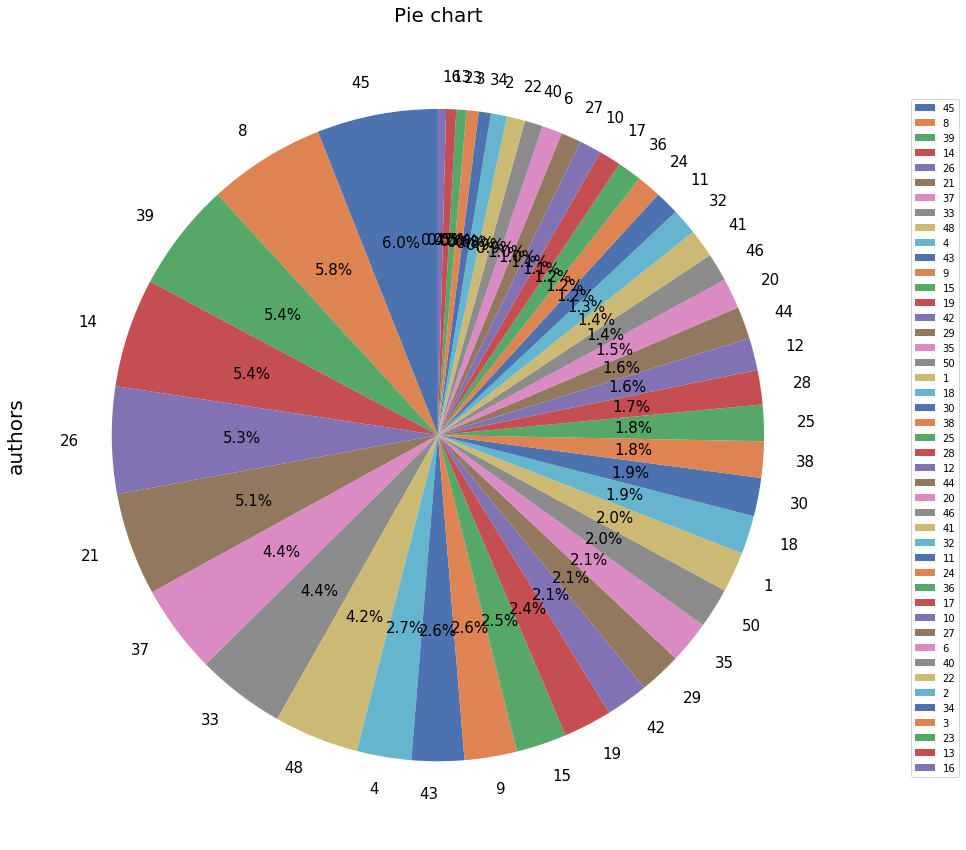

In [29]:
pd.DataFrame(victorian_df['author']).apply(pd.value_counts).plot(kind='pie', figsize=(15, 15), subplots=True, autopct='%1.1f%%', 
                                                                 shadow = False, startangle = 90, fontsize = 15)
plt.legend(bbox_to_anchor=(1, 0.5), loc="center right", fontsize=10, bbox_transform=plt.gcf().transFigure)
plt.ylabel('authors', size=20)
plt.title('Pie chart', size=20)
plt.show()

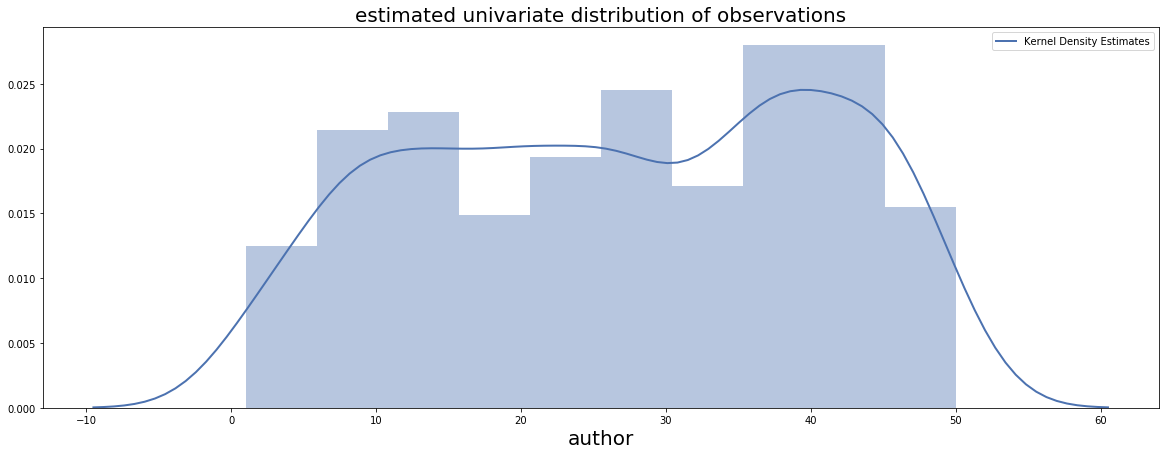

In [30]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.distplot(victorian_df.loc[:, 'author'], ax=ax,
             kde_kws={"lw": 2, "label": "Kernel Density Estimates"})
ax.set_xlabel('author', size=20)
plt.title('estimated univariate distribution of observations', size=20)
plt.show()

# am realizat acest plot pentru a putea vizualiza
# cum sunt distribuite variabilele unui anumit atribut

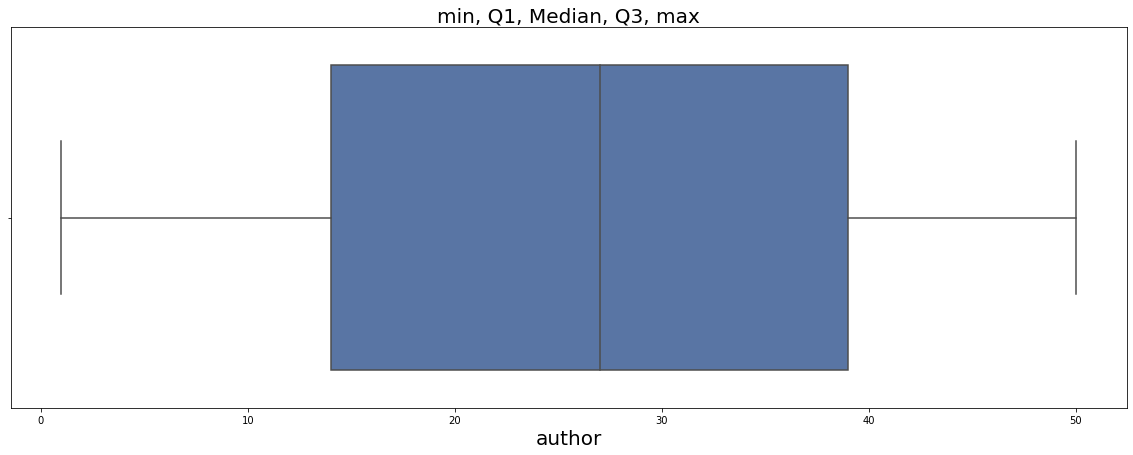

In [31]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(victorian_df.loc[:, 'author'])
ax.set_xlabel('author', size=20)
plt.title('min, Q1, Median, Q3, max', size=20)
plt.show()

# am realizat acest plot pentru a putea vizualiza
# distributia valorilor pe quantilele 1, 2, 3
# eliminarea automata a outlayere-lor

#### Statistici asupra textelor

In [32]:
stats_victorian_df = victorian_df.copy()

In [33]:
stats_victorian_df.loc[:, 'word_count'] = stats_victorian_df.loc[:, 'text'].apply(lambda x: len(str(x).split(' ')))
stats_victorian_df.loc[:, ['text', 'word_count']].head(10)

# extragerea numarului de cuvinte din fiecare text

,text,word_count
0,long since dead that i want you to begin as soon as possible to reap the benefits mr intended for you to this refused to listen though he began to think he had been rude to the man of the law he persisted that if mr had intended him to have two thousand five hundred dollars a year or any sum from his estate he would have made his will in that manner instead of that he should wait five years and then depend upon a he would have been glad now had the will read differently he did not like to be...,1001
1,life might possibly be saved on the other hand every cent thrown into the pit might merely be added to what had gone before it but the pressed gray had to choose and he chose to make one more attempt to save his father in law from ruin there was no help for it he must go to again during the month that had passed much might have happened to influence the opinion of the new firm but it was either there or nowhere well said the when he had been colonel he was the of business coolness and sagaci...,1001
2,i a look of comprehension filled the eyes of the mother it was mr who had made all this i understand she replied it is very disagreeable i know but you must not let her see that you mind it and above all keep it from him my poor child i did not imagine you were taking it so to heart y fa s in a few days she will be gone and that will end it there is nothing to be jealous of in his sentiments toward i am certain and i thought she added smiling a little that you could never learn to him the gi...,1001
3,be a liberal allowance and said when that was expended she must tell him and he would provide more the widow smiled as she took the sum fa s ma remembering the time before s birth and the extravagant that were on the ing infant s but she knew that mr had not as yet the income that her husband then had and also that he was inclined to economy and she decided to make the money go as far as she could the best way she said to her daughter a fortnight later would be for mr to give us an order on ...,1001
4,his bells in person and that it was doubtful if she the pretty girl would even so much as get a glimpse of him made up his mind as he was to be forced to remain for some time in that he would get all the fun possible out of his residence at the hotel before he had been in the house an hour he had the cordial ill will of every person with whom he came in contact except the landlord who could not afford to harbor such a feeling against a guest of his description nothing done in anticipation of...,1001
5,quite as likely to both his former intended as to them to the other world while laboring to secure the longest delay possible in the interest of for whom he had always entertained a warm liking grew uneasy over the present financial condition of the young man he thought it a great hardship to be deprived of his income after the way he had been brought up with no alternative but work or some method of getting a living if found the former plan too difficult it was not impossible that he would ...,1001
6,husband and wife were lost together at sea the jury disposed of the estate on the theory that the wife probably lived some seconds the longer and therefore inherited her legal share of her husband s property which thus went to her the two daughters of mrs exclaimed how dreadful but exactly what they meant by it has never at any rate said their mother a man in a boat sprang after miss and held her up till she was pulled aboard the i got that straight and it was in the newspaper too and then n...,1001
7,his companion in these days he said with a wealth of meaning it is something to have a wife to whom such a thing would be morally impossible there was a great deal in this admitted to himself a very great deal it was the only thing that had been said which had a distinctly favorable effect upon him he knew the the that pervaded his circle in relation to married women everybody knew all about some of them except the husbands they

In [34]:
stats_victorian_df.loc[:, 'char_count'] = stats_victorian_df.loc[:, 'text'].str.len() - stats_victorian_df.loc[:, 'text'].str.count(' ')
stats_victorian_df.loc[:, ['text', 'char_count']].head(10)

# extragerea numarului de caractere, fara spatii luate in considerare

,text,char_count
0,long since dead that i want you to begin as soon as possible to reap the benefits mr intended for you to this refused to listen though he began to think he had been rude to the man of the law he persisted that if mr had intended him to have two thousand five hundred dollars a year or any sum from his estate he would have made his will in that manner instead of that he should wait five years and then depend upon a he would have been glad now had the will read differently he did not like to be...,4109
1,life might possibly be saved on the other hand every cent thrown into the pit might merely be added to what had gone before it but the pressed gray had to choose and he chose to make one more attempt to save his father in law from ruin there was no help for it he must go to again during the month that had passed much might have happened to influence the opinion of the new firm but it was either there or nowhere well said the when he had been colonel he was the of business coolness and sagaci...,3987
2,i a look of comprehension filled the eyes of the mother it was mr who had made all this i understand she replied it is very disagreeable i know but you must not let her see that you mind it and above all keep it from him my poor child i did not imagine you were taking it so to heart y fa s in a few days she will be gone and that will end it there is nothing to be jealous of in his sentiments toward i am certain and i thought she added smiling a little that you could never learn to him the gi...,3882
3,be a liberal allowance and said when that was expended she must tell him and he would provide more the widow smiled as she took the sum fa s ma remembering the time before s birth and the extravagant that were on the ing infant s but she knew that mr had not as yet the income that her husband then had and also that he was inclined to economy and she decided to make the money go as far as she could the best way she said to her daughter a fortnight later would be for mr to give us an order on ...,4079
4,his bells in person and that it was doubtful if she the pretty girl would even so much as get a glimpse of him made up his mind as he was to be forced to remain for some time in that he would get all the fun possible out of his residence at the hotel before he had been in the house an hour he had the cordial ill will of every person with whom he came in contact except the landlord who could not afford to harbor such a feeling against a guest of his description nothing done in anticipation of...,4045
5,quite as likely to both his former intended as to them to the other world while laboring to secure the longest delay possible in the interest of for whom he had always entertained a warm liking grew uneasy over the present financial condition of the young man he thought it a great hardship to be deprived of his income after the way he had been brought up with no alternative but work or some method of getting a living if found the former plan too difficult it was not impossible that he would ...,3859
6,husband and wife were lost together at sea the jury disposed of the estate on the theory that the wife probably lived some seconds the longer and therefore inherited her legal share of her husband s property which thus went to her the two daughters of mrs exclaimed how dreadful but exactly what they meant by it has never at any rate said their mother a man in a boat sprang after miss and held her up till she was pulled aboard the i got that straight and it was in the newspaper too and then n...,4153
7,his companion in these days he said with a wealth of meaning it is something to have a wife to whom such a thing would be morally impossible there was a great deal in this admitted to himself a very great deal it was the only thing that had been said which had a distinctly favorable effect upon him he knew the the that pervaded his circle in relation to married women everybody knew all about some of them except the husbands they

In [35]:
stats_victorian_df.loc[:, 'avg_word_len'] = stats_victorian_df.loc[:, 'text'].apply(lambda x: avg_word(x))
stats_victorian_df.loc[:, ['text', 'avg_word_len']].head(10)

# determinarea lungimii medii a unui cuvant

,text,avg_word_len
0,long since dead that i want you to begin as soon as possible to reap the benefits mr intended for you to this refused to listen though he began to think he had been rude to the man of the law he persisted that if mr had intended him to have two thousand five hundred dollars a year or any sum from his estate he would have made his will in that manner instead of that he should wait five years and then depend upon a he would have been glad now had the will read differently he did not like to be...,4.11
1,life might possibly be saved on the other hand every cent thrown into the pit might merely be added to what had gone before it but the pressed gray had to choose and he chose to make one more attempt to save his father in law from ruin there was no help for it he must go to again during the month that had passed much might have happened to influence the opinion of the new firm but it was either there or nowhere well said the when he had been colonel he was the of business coolness and sagaci...,3.99
2,i a look of comprehension filled the eyes of the mother it was mr who had made all this i understand she replied it is very disagreeable i know but you must not let her see that you mind it and above all keep it from him my poor child i did not imagine you were taking it so to heart y fa s in a few days she will be gone and that will end it there is nothing to be jealous of in his sentiments toward i am certain and i thought she added smiling a little that you could never learn to him the gi...,3.88
3,be a liberal allowance and said when that was expended she must tell him and he would provide more the widow smiled as she took the sum fa s ma remembering the time before s birth and the extravagant that were on the ing infant s but she knew that mr had not as yet the income that her husband then had and also that he was inclined to economy and she decided to make the money go as far as she could the best way she said to her daughter a fortnight later would be for mr to give us an order on ...,4.08
4,his bells in person and that it was doubtful if she the pretty girl would even so much as get a glimpse of him made up his mind as he was to be forced to remain for some time in that he would get all the fun possible out of his residence at the hotel before he had been in the house an hour he had the cordial ill will of every person with whom he came in contact except the landlord who could not afford to harbor such a feeling against a guest of his description nothing done in anticipation of...,4.04
5,quite as likely to both his former intended as to them to the other world while laboring to secure the longest delay possible in the interest of for whom he had always entertained a warm liking grew uneasy over the present financial condition of the young man he thought it a great hardship to be deprived of his income after the way he had been brought up with no alternative but work or some method of getting a living if found the former plan too difficult it was not impossible that he would ...,3.86
6,husband and wife were lost together at sea the jury disposed of the estate on the theory that the wife probably lived some seconds the longer and therefore inherited her legal share of her husband s property which thus went to her the two daughters of mrs exclaimed how dreadful but exactly what they meant by it has never at any rate said their mother a man in a boat sprang after miss and held her up till she was pulled aboard the i got that straight and it was in the newspaper too and then n...,4.15
7,his companion in these days he said with a wealth of meaning it is something to have a wife to whom such a thing would be morally impossible there was a great deal in this admitted to himself a very great deal it was the only thing that had been said which had a distinctly favorable effect upon him he knew the the that pervaded his circle in relation to married women everybody knew all about some of them except the husbands th

In [36]:
stats_victorian_df.loc[:, 'stopwords'] = stats_victorian_df.loc[:, 'text'].apply(lambda x: [x for x in x.split() if x in stopwrd])
stats_victorian_df.loc[:, 'stopwords_count'] = stats_victorian_df.loc[:, 'text'].apply(lambda x: len([x for x in x.split() if x in stopwrd]))
stats_victorian_df.loc[:, ['text', 'stopwords', 'stopwords_count']].head(10)

# determinarea (numarului de) english-stopwords

,text,stopwords,stopwords_count
0,long since dead that i want you to begin as soon as possible to reap the benefits mr intended for you to this refused to listen though he began to think he had been rude to the man of the law he persisted that if mr had intended him to have two thousand five hundred dollars a year or any sum from his estate he would have made his will in that manner instead of that he should wait five years and then depend upon a he would have been glad now had the will read differently he did not like to be...,"[since, that, i, want, you, to, begin, as, soon, as, possible, to, the, mr, for, you, to, this, to, though, he, to, think, he, had, been, to, the, of, the, he, that, if, mr, had, him, to, have, two, thousand, five, hundred, a, or, any, from, his, he, would, have, made, his, will, in, that, instead, of, that, he, should, five, and, then, upon, a, he, would, have, been, now, had, the, will, he, did, not, like, to, be, to, with, but, his, was, in, becoming, a, and, he, had, not, yet, that, with...",713
1,life might possibly be saved on the other hand every cent thrown into the pit might merely be added to what had gone before it but the pressed gray had to choose and he chose to make one more attempt to save his father in law from ruin there was no help for it he must go to again during the month that had passed much might have happened to influence the opinion of the new firm but it was either there or nowhere well said the when he had been colonel he was the of business coolness and sagaci...,"[might, possibly, be, on, the, other, every, into, the, might, merely, be, added, to, what, had, gone, before, it, but, the, had, to, and, he, to, make, one, more, to, his, in, from, there, was, no, help, for, it, he, must, go, to, again, during, the, that, had, much, might, have, to, the, of, the, new, but, it, was, either, there, or, nowhere, well, said, the, when, he, had, been, he, was, the, of, and, i, should, like, that, we, about, the, thousand, and, the, the, same, as, before, with, ...",731
2,i a look of comprehension filled the eyes of the mother it was mr who had made all this i understand she replied it is very disagreeable i know but you must not let her see that you mind it and above all keep it from him my poor child i did not imagine you were taking it so to heart y fa s in a few days she will be gone and that will end it there is nothing to be jealous of in his sentiments toward i am certain and i thought she added smiling a little that you could never learn to him the gi...,"[i, a, look, of, the, of, the, it, was, mr, who, had, made, all, this, i, she, it, is, very, i, know, but, you, must, not, let, her, see, that, you, it, and, above, all, keep, it, from, him, my, i, did, not, you, were, taking, it, so, to, y, s, in, a, few, she, will, be, gone, and, that, will, end, it, there, is, nothing, to, be, of, in, his, toward, i, am, certain, and, i, she, added, a, little, that, you, could, never, to, him, the, to, like, him, oh, i, him, i, him, as, i, never, i, ...]",763
3,be a liberal allowance and said when that was expended she must tell him and he would provide more the widow smiled as she took the sum fa s ma remembering the time before s birth and the extravagant that were on the ing infant s but she knew that mr had not as yet the income that her husband then had and also that he was inclined to economy and she decided to make the money go as far as she could the best way she said to her daughter a fortnight later would be for mr to give us an order on ...,"[be, a, and, said, when, that, was, she, must, tell, him, and, he, would, more, the, as, she, took, the, s, ma, the, before, s, and, the, that, were, on, the, s, but, she, that, mr, had, not, as, yet, the, that, her, then, had, and, also, that, he, was, to, and, she, to, make, the, go, as, far, as, she, could, the, best, way, she, said, to, her, a, later, would, be, for, mr, to, give, us, an, on, mr, to, get, whatever, we, need, and, then, h

In [37]:
stats_victorian_df.loc[:, 'special_characters'] = stats_victorian_df.loc[:, 'text'].apply(lambda x: [x for x in x.split() if set(x).difference(ascii_letters + digits)])
stats_victorian_df.loc[:, 'special_characters_count'] = stats_victorian_df.loc[:, 'text'].apply(lambda x: len([x for x in x.split() if set(x).difference(ascii_letters + digits)]))
stats_victorian_df.loc[:, ['text', 'special_characters', 'special_characters_count']].head(10)

# determinarea (numarului de) cuvinte care contin caractere speciale

,text,special_characters,special_characters_count
0,long since dead that i want you to begin as soon as possible to reap the benefits mr intended for you to this refused to listen though he began to think he had been rude to the man of the law he persisted that if mr had intended him to have two thousand five hundred dollars a year or any sum from his estate he would have made his will in that manner instead of that he should wait five years and then depend upon a he would have been glad now had the will read differently he did not like to be...,[],0
1,life might possibly be saved on the other hand every cent thrown into the pit might merely be added to what had gone before it but the pressed gray had to choose and he chose to make one more attempt to save his father in law from ruin there was no help for it he must go to again during the month that had passed much might have happened to influence the opinion of the new firm but it was either there or nowhere well said the when he had been colonel he was the of business coolness and sagaci...,[],0
2,i a look of comprehension filled the eyes of the mother it was mr who had made all this i understand she replied it is very disagreeable i know but you must not let her see that you mind it and above all keep it from him my poor child i did not imagine you were taking it so to heart y fa s in a few days she will be gone and that will end it there is nothing to be jealous of in his sentiments toward i am certain and i thought she added smiling a little that you could never learn to him the gi...,[],0
3,be a liberal allowance and said when that was expended she must tell him and he would provide more the widow smiled as she took the sum fa s ma remembering the time before s birth and the extravagant that were on the ing infant s but she knew that mr had not as yet the income that her husband then had and also that he was inclined to economy and she decided to make the money go as far as she could the best way she said to her daughter a fortnight later would be for mr to give us an order on ...,[],0
4,his bells in person and that it was doubtful if she the pretty girl would even so much as get a glimpse of him made up his mind as he was to be forced to remain for some time in that he would get all the fun possible out of his residence at the hotel before he had been in the house an hour he had the cordial ill will of every person with whom he came in contact except the landlord who could not afford to harbor such a feeling against a guest of his description nothing done in anticipation of...,[],0
5,quite as likely to both his former intended as to them to the other world while laboring to secure the longest delay possible in the interest of for whom he had always entertained a warm liking grew uneasy over the present financial condition of the young man he thought it a great hardship to be deprived of his income after the way he had been brought up with no alternative but work or some method of getting a living if found the former plan too difficult it was not impossible that he would ...,[],0
6,husband and wife were lost together at sea the jury disposed of the estate on the theory that the wife probably lived some seconds the longer and therefore inherited her legal share of her husband s property which thus went to her the two daughters of mrs exclaimed how dreadful but exactly what they meant by it has never at any rate said their mother a man in a boat sprang after miss and held her up till she was pulled aboard the i got that straight and it was in the newspaper too and then n...,[],0
7,his companion in these days he said with a wealth of meaning it is something to have a wife to whom such a thing would be morally impossible there was a great deal in this admitted to himself a very great deal it was the only thing that had been said which had a distinctly favorable effect upon him he knew the the that pervaded his circle in relation to married women everybody knew all about some

In [38]:
stats_victorian_df.loc[:, 'numerics'] = stats_victorian_df.loc[:, 'text'].apply(lambda x: [x for x in x.split() if x.isdigit()])
stats_victorian_df.loc[:, 'numerics_count'] = stats_victorian_df.loc[:, 'text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
stats_victorian_df.loc[:, ['text', 'numerics', 'numerics_count']].head(10)

# determinarea exclusiva a numerelor si contorizarea lor

,text,numerics,numerics_count
0,long since dead that i want you to begin as soon as possible to reap the benefits mr intended for you to this refused to listen though he began to think he had been rude to the man of the law he persisted that if mr had intended him to have two thousand five hundred dollars a year or any sum from his estate he would have made his will in that manner instead of that he should wait five years and then depend upon a he would have been glad now had the will read differently he did not like to be...,[],0
1,life might possibly be saved on the other hand every cent thrown into the pit might merely be added to what had gone before it but the pressed gray had to choose and he chose to make one more attempt to save his father in law from ruin there was no help for it he must go to again during the month that had passed much might have happened to influence the opinion of the new firm but it was either there or nowhere well said the when he had been colonel he was the of business coolness and sagaci...,[],0
2,i a look of comprehension filled the eyes of the mother it was mr who had made all this i understand she replied it is very disagreeable i know but you must not let her see that you mind it and above all keep it from him my poor child i did not imagine you were taking it so to heart y fa s in a few days she will be gone and that will end it there is nothing to be jealous of in his sentiments toward i am certain and i thought she added smiling a little that you could never learn to him the gi...,[],0
3,be a liberal allowance and said when that was expended she must tell him and he would provide more the widow smiled as she took the sum fa s ma remembering the time before s birth and the extravagant that were on the ing infant s but she knew that mr had not as yet the income that her husband then had and also that he was inclined to economy and she decided to make the money go as far as she could the best way she said to her daughter a fortnight later would be for mr to give us an order on ...,[],0
4,his bells in person and that it was doubtful if she the pretty girl would even so much as get a glimpse of him made up his mind as he was to be forced to remain for some time in that he would get all the fun possible out of his residence at the hotel before he had been in the house an hour he had the cordial ill will of every person with whom he came in contact except the landlord who could not afford to harbor such a feeling against a guest of his description nothing done in anticipation of...,[],0
5,quite as likely to both his former intended as to them to the other world while laboring to secure the longest delay possible in the interest of for whom he had always entertained a warm liking grew uneasy over the present financial condition of the young man he thought it a great hardship to be deprived of his income after the way he had been brought up with no alternative but work or some method of getting a living if found the former plan too difficult it was not impossible that he would ...,[],0
6,husband and wife were lost together at sea the jury disposed of the estate on the theory that the wife probably lived some seconds the longer and therefore inherited her legal share of her husband s property which thus went to her the two daughters of mrs exclaimed how dreadful but exactly what they meant by it has never at any rate said their mother a man in a boat sprang after miss and held her up till she was pulled aboard the i got that straight and it was in the newspaper too and then n...,[],0
7,his companion in these days he said with a wealth of meaning it is something to have a wife to whom such a thing would be morally impossible there was a great deal in this admitted to himself a very great deal it was the only thing that had been said which had a distinctly favorable effect upon him he knew the the that pervaded his circle in relation to married women everybody knew all about some of them except the 

In [39]:
stats_victorian_df.loc[:, 'uppercase_words'] = stats_victorian_df.loc[:, 'text'].apply(lambda x: [x for x in x.split() if x.isupper()])
stats_victorian_df.loc[:, 'uppercase_words_count'] = stats_victorian_df.loc[:, 'text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
stats_victorian_df.loc[:, ['text', 'uppercase_words', 'uppercase_words_count']].head(10)

# determinarea si numararea cuvintelor care incep cu majuscula

,text,uppercase_words,uppercase_words_count
0,long since dead that i want you to begin as soon as possible to reap the benefits mr intended for you to this refused to listen though he began to think he had been rude to the man of the law he persisted that if mr had intended him to have two thousand five hundred dollars a year or any sum from his estate he would have made his will in that manner instead of that he should wait five years and then depend upon a he would have been glad now had the will read differently he did not like to be...,[],0
1,life might possibly be saved on the other hand every cent thrown into the pit might merely be added to what had gone before it but the pressed gray had to choose and he chose to make one more attempt to save his father in law from ruin there was no help for it he must go to again during the month that had passed much might have happened to influence the opinion of the new firm but it was either there or nowhere well said the when he had been colonel he was the of business coolness and sagaci...,[],0
2,i a look of comprehension filled the eyes of the mother it was mr who had made all this i understand she replied it is very disagreeable i know but you must not let her see that you mind it and above all keep it from him my poor child i did not imagine you were taking it so to heart y fa s in a few days she will be gone and that will end it there is nothing to be jealous of in his sentiments toward i am certain and i thought she added smiling a little that you could never learn to him the gi...,[],0
3,be a liberal allowance and said when that was expended she must tell him and he would provide more the widow smiled as she took the sum fa s ma remembering the time before s birth and the extravagant that were on the ing infant s but she knew that mr had not as yet the income that her husband then had and also that he was inclined to economy and she decided to make the money go as far as she could the best way she said to her daughter a fortnight later would be for mr to give us an order on ...,[],0
4,his bells in person and that it was doubtful if she the pretty girl would even so much as get a glimpse of him made up his mind as he was to be forced to remain for some time in that he would get all the fun possible out of his residence at the hotel before he had been in the house an hour he had the cordial ill will of every person with whom he came in contact except the landlord who could not afford to harbor such a feeling against a guest of his description nothing done in anticipation of...,[],0
5,quite as likely to both his former intended as to them to the other world while laboring to secure the longest delay possible in the interest of for whom he had always entertained a warm liking grew uneasy over the present financial condition of the young man he thought it a great hardship to be deprived of his income after the way he had been brought up with no alternative but work or some method of getting a living if found the former plan too difficult it was not impossible that he would ...,[],0
6,husband and wife were lost together at sea the jury disposed of the estate on the theory that the wife probably lived some seconds the longer and therefore inherited her legal share of her husband s property which thus went to her the two daughters of mrs exclaimed how dreadful but exactly what they meant by it has never at any rate said their mother a man in a boat sprang after miss and held her up till she was pulled aboard the i got that straight and it was in the newspaper too and then n...,[],0
7,his companion in these days he said with a wealth of meaning it is something to have a wife to whom such a thing would be morally impossible there was a great deal in this admitted to himself a very great deal it was the only thing that had been said which had a distinctly favorable effect upon him he knew the the that pervaded his circle in relation to married women everybody knew all about some of th

In [40]:
stats_victorian_df.mask(stats_victorian_df.applymap(str).eq('[]'), inplace=True)
stats_victorian_df.fillna(value='-', inplace=True)
stats_victorian_df.insert(len(stats_sms_df.columns) - 1, 'author', stats_victorian_df.pop('author'))
stats_victorian_df.head(5)

# inlocuire liste vide cu caracterul "-" si mutarea coloanei "author" pe ultima pozitie

,text,word_count,char_count,avg_word_len,stopwords,stopwords_count,special_characters,special_characters_count,numerics,numerics_count,uppercase_words,uppercase_words_count,author
0,long since dead that i want you to begin as soon as possible to reap the benefits mr intended for you to this refused to listen though he began to think he had been rude to the man of the law he persisted that if mr had intended him to have two thousand five hundred dollars a year or any sum from his estate he would have made his will in that manner instead of that he should wait five years and then depend upon a he would have been glad now had the will read differently he did not like to be...,1001,4109,4.11,"[since, that, i, want, you, to, begin, as, soon, as, possible, to, the, mr, for, you, to, this, to, though, he, to, think, he, had, been, to, the, of, the, he, that, if, mr, had, him, to, have, two, thousand, five, hundred, a, or, any, from, his, he, would, have, made, his, will, in, that, instead, of, that, he, should, five, and, then, upon, a, he, would, have, been, now, had, the, will, he, did, not, like, to, be, to, with, but, his, was, in, becoming, a, and, he, had, not, yet, that, with...",713,-,0,-,0,-,0,1
1,life might possibly be saved on the other hand every cent thrown into the pit might merely be added to what had gone before it but the pressed gray had to choose and he chose to make one more attempt to save his father in law from ruin there was no help for it he must go to again during the month that had passed much might have happened to influence the opinion of the new firm but it was either there or nowhere well said the when he had been colonel he was the of business coolness and sagaci...,1001,3987,3.99,"[might, possibly, be, on, the, other, every, into, the, might, merely, be, added, to, what, had, gone, before, it, but, the, had, to, and, he, to, make, one, more, to, his, in, from, there, was, no, help, for, it, he, must, go, to, again, during, the, that, had, much, might, have, to, the, of, the, new, but, it, was, either, there, or, nowhere, well, said, the, when, he, had, been, he, was, the, of, and, i, should, like, that, we, about, the, thousand, and, the, the, same, as, before, with, ...",731,-,0,-,0,-,0,1
2,i a look of comprehension filled the eyes of the mother it was mr who had made all this i understand she replied it is very disagreeable i know but you must not let her see that you mind it and above all keep it from him my poor child i did not imagine you were taking it so to heart y fa s in a few days she will be gone and that will end it there is nothing to be jealous of in his sentiments toward i am certain and i thought she added smiling a little that you could never learn to him the gi...,1001,3882,3.88,"[i, a, look, of, the, of, the, it, was, mr, who, had, made, all, this, i, she, it, is, very, i, know, but, you, must, not, let, her, see, that, you, it, and, above, all, keep, it, from, him, my, i, did, not, you, were, taking, it, so, to, y, s, in, a, few, she, will, be, gone, and, that, will, end, it, there, is, nothing, to, be, of, in, his, toward, i, am, certain, and, i, she, added, a, little, that, you, could, never, to, him, the, to, like, him, oh, i, him, i, him, as, i, never, i, ...]",763,-,0,-,0,-,0,1
3,be a liberal allowance and said when that was expended she must tell him and he would provide more the widow smiled as she took the sum fa s ma remembering the time before s birth and the extravagant that were on the ing infant s but she knew that mr had not as yet the income that her husband then had and also that he was inclined to economy and she decided to make the money go as far as she could the best way she said to her daughter a fortnight later would be for mr to give us an order on ...,1001,4079,4.08,"[be, a, and, said, when, that, was, she, must, tell, him, and, he, would, more, the, as, she, took, the, s, ma, the, before, s, and, the, that, were, on, the, s, but, she, that, mr, had, not, as,

##  Se face preprocesare de date; se explica in limba romana care sunt metodele de preprocesare folosite, efectul lor pe datele de intrare, ce forma are iesirea obtinuta; se arata efectele pasilor de preprocesare asupra setului de date (noul numar de documente, dinamica vocabularului, trasaturile rezultate etc.) Se pot aduga grafice si tabele la acest pas.

In [41]:
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
                "J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV
                }

    return tag_dict.get(tag, wordnet.NOUN)


Lemmatizer = WordNetLemmatizer()

# word = 'mice'
# print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))
sentence = 'This is an example. The striped cats are chasing on their paws for the best hunting of mice.'
print([Lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(sentence)])

# obtinem radacina cuvantului din orice forma ar fi acesta

['This', 'be', 'an', 'example', '.', 'The', 'strip', 'cat', 'be', 'chase', 'on', 'their', 'paw', 'for', 'the', 'best', 'hunt', 'of', 'mouse', '.']


### [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

#### Preprocesare

In [42]:
preproc_sms_df = sms_df.copy()

In [43]:
preproc_sms_df.loc[:, 'message'] = preproc_sms_df.loc[:, 'message'].apply(lambda x: " ".join(x.lower() for x in x.split()))
preproc_sms_df.head(10)

# am aplicat lower case pe toate cuvintele

,message,class
0,ok lar... joking wif u oni...,0
1,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's,1
2,winner!! as a valued network customer you have been selected to receivea £900 prize reward! to claim call 09061701461. claim code kl341. valid 12 hours only.,1
3,had your mobile 11 months or more? u r entitled to update to the latest colour mobiles with camera for free! call the mobile update co free on 08002986030,1
4,"six chances to win cash! from 100 to 20,000 pounds txt> csh11 and send to 87575. cost 150p/day, 6days, 16+ tsandcs apply reply hl 4 info",1
5,i have a date on sunday with will!!,0
6,"xxxmobilemovieclub: to use your credit, click the wap link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=qjkgighjjgcbl",1
7,aft i finish my lunch then i go str down lor. ard 3 smth lor. u finish ur lunch already?,0
8,did you catch the bus ? are you frying an egg ? did you make a tea? are you eating your mom's left over dinner ? do you feel my love ?,0
9,"wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us",0


In [44]:
preproc_sms_df.loc[:, 'message'] = preproc_sms_df.loc[:, 'message'].apply(lambda x: str(TextBlob(x).correct()))
preproc_sms_df.head(10)

# am corectat toate cuvintele, exemplu: u -> you

,message,class
0,ok war... joking if u on...,0
1,free entry in 2 a wily come to win a cup final this must may 2005. text a to 87121 to receive entry question(st txt rate)t&c's apply 08452810075over18's,1
2,winner!! as a valued network customer you have been selected to received £900 prize reward! to claim call 09061701461. claim code kl341. valid 12 hours only.,1
3,had your mobile 11 months or more? u r entitled to update to the latest colour mobile with camera for free! call the mobile update co free on 08002986030,1
4,"six chances to win cash! from 100 to 20,000 pounds txt> csh11 and send to 87575. cost 150p/day, days, 16+ stands apply reply he 4 into",1
5,i have a date on sunday with will!!,0
6,"xxxmobilemovieclub: to use your credit, click the was link in the next txt message or click here>> http://was. xxxmobilemovieclub.com?n=qjkgighjjgcbl",1
7,aft i finish my lunch then i go sir down for. and 3 smith for. u finish or lunch already?,0
8,did you catch the bus ? are you trying an egg ? did you make a tea? are you eating your mon's left over dinner ? do you feel my love ?,0
9,"wait that's still not all that clear, were you not sure about me being sarcastic or that that's why x doesn't want to live with us",0


In [45]:
preproc_sms_df.loc[:, 'message'] = preproc_sms_df.loc[:, 'message'].str.replace('[^\w\s]','')
preproc_sms_df.head(10)

# am eliminat toate semnele de punctuatie
# ^ -> the start of the string
# \w -> [a-zA-Z0-9_]
# \s -> [ \t\n\r\f\v]

,message,class
0,ok war joking if u on,0
1,free entry in 2 a wily come to win a cup final this must may 2005 text a to 87121 to receive entry questionst txt ratetcs apply 08452810075over18s,1
2,winner as a valued network customer you have been selected to received 900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only,1
3,had your mobile 11 months or more u r entitled to update to the latest colour mobile with camera for free call the mobile update co free on 08002986030,1
4,six chances to win cash from 100 to 20000 pounds txt csh11 and send to 87575 cost 150pday days 16 stands apply reply he 4 into,1
5,i have a date on sunday with will,0
6,xxxmobilemovieclub to use your credit click the was link in the next txt message or click here httpwas xxxmobilemovieclubcomnqjkgighjjgcbl,1
7,aft i finish my lunch then i go sir down for and 3 smith for u finish or lunch already,0
8,did you catch the bus are you trying an egg did you make a tea are you eating your mons left over dinner do you feel my love,0
9,wait thats still not all that clear were you not sure about me being sarcastic or that thats why x doesnt want to live with us,0


In [46]:
preproc_sms_df.loc[:, 'message'] = preproc_sms_df.loc[:, 'message'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwrd))
preproc_sms_df.head(10)

# am eliminat toate english-stopwords

,message,class
0,war joking,0
1,free entry 2 wily win cup final 2005 text 87121 receive entry questionst txt ratetcs apply 08452810075over18s,1
2,winner valued network customer selected received 900 prize reward claim 09061701461 claim code kl341 valid 12 hours,1
3,mobile 11 months entitled update latest colour mobile camera free mobile update free 08002986030,1
4,chances win cash 100 20000 pounds txt csh11 send 87575 cost 150pday days 16 stands apply reply 4,1
5,sunday,0
6,xxxmobilemovieclub credit click link txt message click httpwas xxxmobilemovieclubcomnqjkgighjjgcbl,1
7,aft finish lunch sir 3 smith finish lunch,0
8,catch bus egg tea eating mons left dinner feel love,0
9,wait clear sarcastic doesnt live,0


In [47]:
preproc_sms_df.loc[:, 'message'] = preproc_sms_df.loc[:, 'message'].apply(lambda x: " ".join([Lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(x)]))
preproc_sms_df.head(10)

# am adus toate cuvintele la forma lor de baza (root form), exemplu: mice -> mouse

,message,class
0,war joking,0
1,free entry 2 wily win cup final 2005 text 87121 receive entry questionst txt ratetcs apply 08452810075over18s,1
2,winner value network customer select receive 900 prize reward claim 09061701461 claim code kl341 valid 12 hour,1
3,mobile 11 month entitle update late colour mobile camera free mobile update free 08002986030,1
4,chance win cash 100 20000 pound txt csh11 send 87575 cost 150pday day 16 stand apply reply 4,1
5,sunday,0
6,xxxmobilemovieclub credit click link txt message click httpwas xxxmobilemovieclubcomnqjkgighjjgcbl,1
7,aft finish lunch sir 3 smith finish lunch,0
8,catch bus egg tea eat mon left dinner feel love,0
9,wait clear sarcastic doesnt live,0


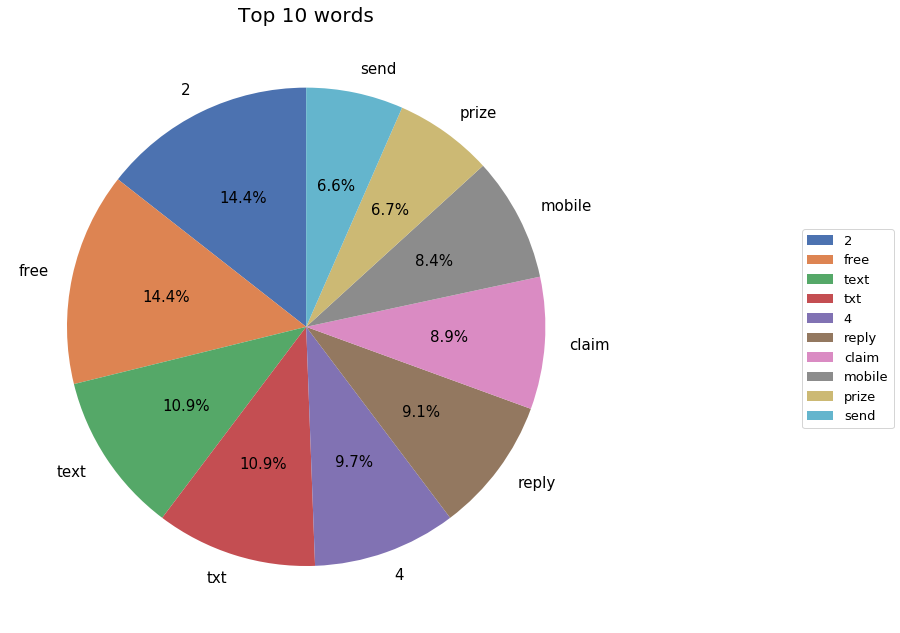

,message,class
0,war joking,0
1,entry wily win cup final 2005 87121 receive entry questionst ratetcs apply 08452810075over18s,1
2,winner value network customer select receive 900 reward 09061701461 code kl341 valid 12 hour,1
3,11 month entitle update late colour camera update 08002986030,1
4,chance win cash 100 20000 pound csh11 87575 cost 150pday day 16 stand apply,1
5,sunday,0
6,xxxmobilemovieclub credit click link message click httpwas xxxmobilemovieclubcomnqjkgighjjgcbl,1
7,aft finish lunch sir 3 smith finish lunch,0
8,catch bus egg tea eat mon left dinner feel love,0
9,wait clear sarcastic doesnt live,0


In [48]:
top_10_words = pd.Series(' '.join(preproc_sms_df['message']).split(), name='').value_counts()[:10]

top_10_words.plot(kind='pie', figsize=(12, 11), subplots=True, autopct='%1.1f%%', shadow = False, startangle = 90, fontsize = 15)
plt.legend(bbox_to_anchor=(1.2, 0.5), loc="center right", fontsize=13, bbox_transform=plt.gcf().transFigure)
plt.title('Top 10 words', size = 20)
plt.show()

top_10_words = list(top_10_words.index)
preproc_sms_df.loc[:, 'message'] = preproc_sms_df.loc[:, 'message'].apply(lambda x: " ".join(x for x in x.split() if x not in top_10_words))
preproc_sms_df.head(10)

# am realizat un pie chart cu cele mai frecvente 10 cuvinte si le-am eliminat 

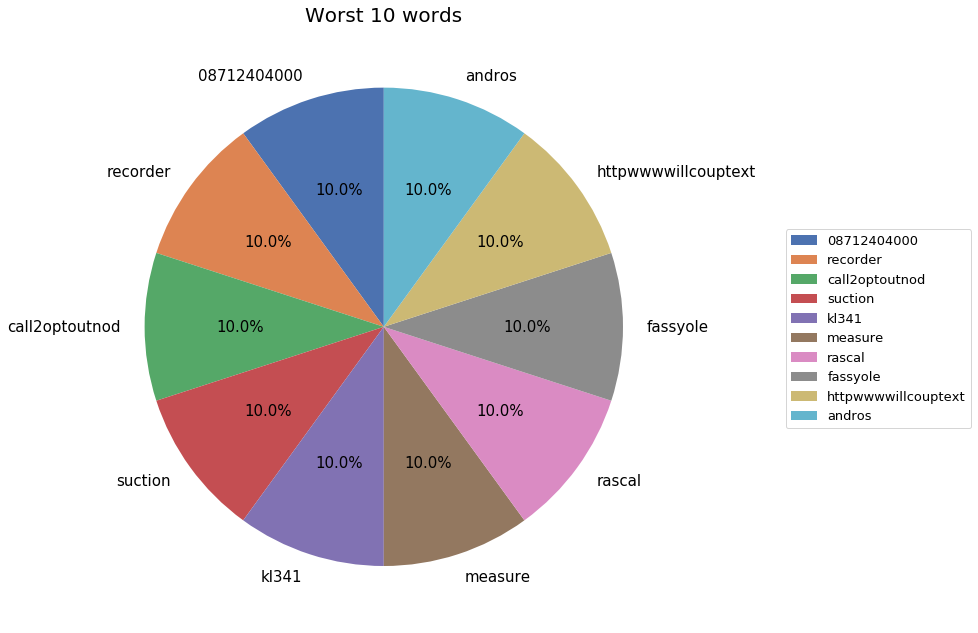

,message,class
0,war joking,0
1,entry wily win cup final 2005 87121 receive entry questionst ratetcs apply 08452810075over18s,1
2,winner value network customer select receive 900 reward 09061701461 code valid 12 hour,1
3,11 month entitle update late colour camera update 08002986030,1
4,chance win cash 100 20000 pound csh11 87575 cost 150pday day 16 stand apply,1
5,sunday,0
6,xxxmobilemovieclub credit click link message click httpwas xxxmobilemovieclubcomnqjkgighjjgcbl,1
7,aft finish lunch sir 3 smith finish lunch,0
8,catch bus egg tea eat mon left dinner feel love,0
9,wait clear sarcastic doesnt live,0


In [49]:
worst_10_words = pd.Series(' '.join(preproc_sms_df['message']).split(), name='').value_counts()[-10:]

worst_10_words.plot(kind='pie', figsize=(12, 11), subplots=True, autopct='%1.1f%%', shadow = False, startangle = 90, fontsize = 15)
plt.legend(bbox_to_anchor=(1.2, 0.5), loc="center right", fontsize=13, bbox_transform=plt.gcf().transFigure)
plt.title('Worst 10 words', size = 20)
plt.show()

worst_10_words = list(worst_10_words.index)
preproc_sms_df.loc[:, 'message'] = preproc_sms_df.loc[:, 'message'].apply(lambda x: " ".join(x for x in x.split() if x not in worst_10_words))
preproc_sms_df.head(10)

# am realizat un pie chart cu cele mai putin frecvente 10 cuvinte si le-am eliminat 

#### N-grams, N = 2

In [50]:
sms_ngrams = TextBlob(preproc_sms_df.loc[1, 'message']).ngrams(2)
sms_ngrams

# N-grams are the combination of multiple words used together.
# The basic principle behind n-grams is that they capture the language structure, 
# like what letter or word is likely to follow the given one.

[WordList(['entry', 'wily']),
 WordList(['wily', 'win']),
 WordList(['win', 'cup']),
 WordList(['cup', 'final']),
 WordList(['final', '2005']),
 WordList(['2005', '87121']),
 WordList(['87121', 'receive']),
 WordList(['receive', 'entry']),
 WordList(['entry', 'questionst']),
 WordList(['questionst', 'ratetcs']),
 WordList(['ratetcs', 'apply']),
 WordList(['apply', '08452810075over18s'])]

#### TF-IDF (Term frequency - Inverse document frequency)

In [51]:
sms_tfidf = preproc_sms_df.loc[:, 'message'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
sms_tfidf.columns = ['words', 'term_frequency']

for i, word in enumerate(sms_tfidf['words']):
    sms_tfidf.loc[i, 'inverse_document_frequency'] = np.log(preproc_sms_df.shape[0] / (len(preproc_sms_df[preproc_sms_df.loc[:, 'message'].str.contains(word)])))

sms_tfidf['tf_idf'] = sms_tfidf['term_frequency'] * sms_tfidf['inverse_document_frequency']
sms_tfidf.head(len(preproc_sms_df.loc[1, 'message'].split()))

# TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection.
# TF = (Number of times term T appears in the particular row) / (number of terms in that row).
# IDF = log(N/n), where N is the total number of rows and n is the number of rows in which the word was present.
# TF-IDF is the multiplication of the TF and IDF (TF * IDF) which we calculated above.
# higher tf_idf value -> the word will be very useful; lower tf_idf value -> the word will not be useful

,words,term_frequency,inverse_document_frequency,tf_idf
0,war,10.0,2.659260,26.592600
1,joking,1.0,6.907755,6.907755
2,entry,18.0,4.074542,73.341755
3,win,53.0,2.645075,140.188996
4,questionst,2.0,6.214608,12.429216
5,87121,4.0,5.298317,21.193269
6,cup,5.0,5.298317,26.491587
7,08452810075over18s,2.0,6.214608,12.429216
8,2005,2.0,6.214608,12.429216
9,receive,24.0,3.816713,91.601108


In [52]:
sms_tfidf_sklearn = tfidf.fit_transform(preproc_sms_df.loc[:, 'message'])
# print(tfidf.get_feature_names())
print(sms_tfidf_sklearn[1])

# sklearn !!! lower tf_idf value -> the word will be very useful; higher tf_idf value -> the word will not be useful

  (0, 54)	0.30719105807558716
  (0, 577)	0.22636859541419024
  (0, 1993)	0.30719105807558716
  (0, 1977)	0.30719105807558716
  (0, 2005)	0.21531164215004697
  (0, 467)	0.2841487995512893
  (0, 292)	0.30719105807558716
  (0, 1148)	0.2377048552999855
  (0, 936)	0.27592466150741685
  (0, 2561)	0.1776556917255064
  (0, 2560)	0.24465826493924653
  (0, 1079)	0.4691854669161254


#### BOW (Bag of words)

In [53]:
sms_bow_sklearn = bow.fit_transform(preproc_sms_df.loc[:, 'message'])
print(sms_bow_sklearn.toarray())
sms_bow_sklearn

# 1000 texte x 2626 cuvinte
# fiecare linie este initializata cu 2626 de 0 la inceput
# numerele reprezinta recurentele fiecarui cuvant din bow, din textul respectiv

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0

<1000x2655 sparse matrix of type '<class 'numpy.int64'>'
	with 7352 stored elements in Compressed Sparse Row format>

### Victorian Era Authorship Attribution Data Set

#### Preprocesare

In [54]:
preproc_victorian_df = victorian_df.copy()

In [55]:
# preproc_victorian_df.loc[:, 'text'] = preproc_victorian_df.loc[:, 'text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# preproc_victorian_df.head(10)

# am aplicat lower case pe toate cuvintele

# din explorarea datelor de la punctul anterior, nu exista cuvinte cu majuscula

In [56]:
preproc_victorian_df.loc[:, 'text'] = preproc_victorian_df.loc[:, 'text'].apply(lambda x: str(TextBlob(x).correct()))
preproc_victorian_df.head(10)

# am corectat toate cuvintele, exemplu: u -> you

,text,author
0,long since dead that i want you to begin as soon as possible to reap the benefits mr intended for you to this refused to listen though he began to think he had been rude to the man of the law he persisted that if mr had intended him to have two thousand five hundred dollars a year or any sum from his estate he would have made his will in that manner instead of that he should wait five years and then depend upon a he would have been glad now had the will read differently he did not like to be...,1
1,life might possibly be saved on the other hand every cent thrown into the pit might merely be added to what had gone before it but the pressed gray had to choose and he chose to make one more attempt to save his father in law from ruin there was no help for it he must go to again during the month that had passed much might have happened to influence the opinion of the new firm but it was either there or nowhere well said the when he had been colonel he was the of business coolness and sagaci...,1
2,i a look of comprehension filled the eyes of the mother it was mr who had made all this i understand she replied it is very disagreeable i know but you must not let her see that you mind it and above all keep it from him my poor child i did not imagine you were taking it so to heart y a s in a few days she will be gone and that will end it there is nothing to be jealous of in his sentiments toward i am certain and i thought she added smiling a little that you could never learn to him the gir...,1
3,be a liberal allowance and said when that was expended she must tell him and he would provide more the widow smiled as she took the sum a s ma remembering the time before s birth and the extravagant that were on the ing infant s but she knew that mr had not as yet the income that her husband then had and also that he was inclined to economy and she decided to make the money go as far as she could the best way she said to her daughter a fortnight later would be for mr to give us an order on m...,1
4,his bells in person and that it was doubtful if she the pretty girl would even so much as get a glimpse of him made up his mind as he was to be forced to remain for some time in that he would get all the fun possible out of his residence at the hotel before he had been in the house an hour he had the cordial ill will of every person with whom he came in contact except the landlord who could not afford to harbor such a feeling against a guest of his description nothing done in anticipation of...,1
5,quite as likely to both his former intended as to them to the other world while laboring to secure the longest delay possible in the interest of for whom he had always entertained a warm liking grew uneasy over the present financial condition of the young man he thought it a great hardship to be deprived of his income after the way he had been brought up with no alternative but work or some method of getting a living if found the former plan too difficult it was not impossible that he would ...,1
6,husband and wife were lost together at sea the jury disposed of the estate on the theory that the wife probably lived some seconds the longer and therefore inherited her legal share of her husband s property which thus went to her the two daughters of mrs exclaimed how dreadful but exactly what they meant by it has never at any rate said their mother a man in a boat sprang after miss and held her up till she was pulled aboard the i got that straight and it was in the newspaper too and then n...,1
7,his companion in these days he said with a wealth of meaning it is something to have a wife to whom such a thing would be morally impossible there was a great deal in this admitted to himself a very great deal it was the only thing that had been said which had a distinctly favorable effect upon him he knew the the that pervaded his circle in relation to married women everybody knew all about some of them except the husbands they were and there were not 

In [57]:
preproc_victorian_df.loc[:, 'text'] = preproc_victorian_df.loc[:, 'text'].str.replace('[^\w\s]','')
preproc_victorian_df.head(10)

# am eliminat toate semnele de punctuatie
# ^ -> the start of the string
# \w -> [a-zA-Z0-9_]
# \s -> [ \t\n\r\f\v]

,text,author
0,long since dead that i want you to begin as soon as possible to reap the benefits mr intended for you to this refused to listen though he began to think he had been rude to the man of the law he persisted that if mr had intended him to have two thousand five hundred dollars a year or any sum from his estate he would have made his will in that manner instead of that he should wait five years and then depend upon a he would have been glad now had the will read differently he did not like to be...,1
1,life might possibly be saved on the other hand every cent thrown into the pit might merely be added to what had gone before it but the pressed gray had to choose and he chose to make one more attempt to save his father in law from ruin there was no help for it he must go to again during the month that had passed much might have happened to influence the opinion of the new firm but it was either there or nowhere well said the when he had been colonel he was the of business coolness and sagaci...,1
2,i a look of comprehension filled the eyes of the mother it was mr who had made all this i understand she replied it is very disagreeable i know but you must not let her see that you mind it and above all keep it from him my poor child i did not imagine you were taking it so to heart y a s in a few days she will be gone and that will end it there is nothing to be jealous of in his sentiments toward i am certain and i thought she added smiling a little that you could never learn to him the gir...,1
3,be a liberal allowance and said when that was expended she must tell him and he would provide more the widow smiled as she took the sum a s ma remembering the time before s birth and the extravagant that were on the ing infant s but she knew that mr had not as yet the income that her husband then had and also that he was inclined to economy and she decided to make the money go as far as she could the best way she said to her daughter a fortnight later would be for mr to give us an order on m...,1
4,his bells in person and that it was doubtful if she the pretty girl would even so much as get a glimpse of him made up his mind as he was to be forced to remain for some time in that he would get all the fun possible out of his residence at the hotel before he had been in the house an hour he had the cordial ill will of every person with whom he came in contact except the landlord who could not afford to harbor such a feeling against a guest of his description nothing done in anticipation of...,1
5,quite as likely to both his former intended as to them to the other world while laboring to secure the longest delay possible in the interest of for whom he had always entertained a warm liking grew uneasy over the present financial condition of the young man he thought it a great hardship to be deprived of his income after the way he had been brought up with no alternative but work or some method of getting a living if found the former plan too difficult it was not impossible that he would ...,1
6,husband and wife were lost together at sea the jury disposed of the estate on the theory that the wife probably lived some seconds the longer and therefore inherited her legal share of her husband s property which thus went to her the two daughters of mrs exclaimed how dreadful but exactly what they meant by it has never at any rate said their mother a man in a boat sprang after miss and held her up till she was pulled aboard the i got that straight and it was in the newspaper too and then n...,1
7,his companion in these days he said with a wealth of meaning it is something to have a wife to whom such a thing would be morally impossible there was a great deal in this admitted to himself a very great deal it was the only thing that had been said which had a distinctly favorable effect upon him he knew the the that pervaded his circle in relation to married women everybody knew all about some of them except the husbands they were and there were not 

In [58]:
preproc_victorian_df.loc[:, 'text'] = preproc_victorian_df.loc[:, 'text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopwrd))
preproc_victorian_df.head(10)

# am eliminat toate english-stopwords

,text,author
0,long dead reap benefits intended refused listen began rude man law persisted intended dollars year sum estate manner wait years depend glad read differently left face face poverty honor tact experienced sharp contact response argument owe apology manner receiving unpleasant news broke yesterday freely situation delay earn bread casting mind moments inquiries gray understanding parted month looked diligence absolutely distress increased place place positions offered office frame mind told gen...,1
1,life saved hand cent thrown pit pressed gray choose chose attempt save father law ruin month passed happened influence opinion firm colonel business coolness sagacity money spoke fifty dollars security life cats love play intend eat talk month stammered gray market easy money risk silent refused sense business profits dangers talked large offered handy smaller naturally larger rate larger rate cent year rate gray point double mind deal firm calling lend dollar price love mode business paused...,1
2,comprehension filled eyes mother understand replied disagreeable mind poor child imagine heart days jealous sentiments thought smiling learn girl quivered crown toe mamma love love thought love man perfectly miserable weeks return word killing room sick disease bid good bye listened utmost astonishment girl told love repeated learn sooner girl sank bed burying hot head comparatively cool pillows began mamma moaned realize live husband widow soothed daughter hair forehead murdering soft assur...,1
3,liberal allowance expended provide widow smiled sum remembering time birth extravagant ing infant knew income husband inclined economy decided money daughter fortnight order foolish reckon time money left owe replied set money satisfied lost future heir needed advance appearance delight affair great forgot opened pocket book freely demands sewing machine whirled day day thought ship crew fitted product supposing crew worn tiny sit watch mother comment work feel mother household work shoulder...,1
4,bells person doubtful pretty girl glimpse mind forced remain time fun residence hotel house hour cordial ill person contact landlord afford harbor feeling guest description anticipation arrival suited rooms sir smiling stairs shocked smiling smile fair creature wore days rooms echoed heir rooms rooms human exist minutes atmosphere throw open windows knock thought began unhappily lungs set motion supplies walked window opened deep breath frosty air heaven continued allusion lace curtains arra...,1
5,intended laboring secure longest delay entertained warm liking grew uneasy financial condition young man thought great hardship deprived income brought alternative work method living plan difficult impossible driven mind address maid lived snug sum laid wanted offer assistance funds enable tide emergency believing temporary result takes journey caution fancy direct interference affairs confide attempt failed total loss turn dark night retire house rung called awaiting letter young master han...,1
6,husband wife lost sea jury disposed estate theory wife lived seconds longer inherited legal share husband property daughters exclaimed dreadful meant rate mother man boat sprang held pulled aboard straight newspaper waiting thanked bowed times good hear honorable brave action hope pecuniary reward turned dispute lady undoubtedly entered lists uttered thought mind man father laugh agreed daughters cried breath funny sugar princess felt flush mounting cheeks color lessen turned opinion knives ...,1
7,companion days wealth meaning wife morally impossible great deal admitted great deal distinctly favorable knew pervaded circle relation married women knew husbands cases giddy young man fashionable stately organ music column society prints grand tour europe bride left arms lover bridegroom husbands suspected day time liable explosion snap revolver man marry great wife ceremony impossible conceive good deal composition suggestion wisely decided time hopi

In [59]:
preproc_victorian_df.loc[:, 'text'] = preproc_victorian_df.loc[:, 'text'].apply(lambda x: " ".join([Lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(x)]))
preproc_victorian_df.head(10)

# am adus toate cuvintele la forma lor de baza (root form), exemplu: mice -> mouse

,text,author
0,long dead reap benefit intend refuse listen begin rude man law persist intend dollar year sum estate manner wait year depend glad read differently left face face poverty honor tact experienced sharp contact response argument owe apology manner receive unpleasant news broke yesterday freely situation delay earn bread cast mind moment inquiry gray understand part month look diligence absolutely distress increase place place position offer office frame mind told gentleman frankly occur lead off...,1
1,life save hand cent thrown pit press gray choose chose attempt save father law ruin month pass happen influence opinion firm colonel business coolness sagacity money spoke fifty dollar security life cat love play intend eat talk month stammer gray market easy money risk silent refuse sense business profit danger talk large offer handy small naturally large rate large rate cent year rate gray point double mind deal firm call lend dollar price love mode business pause stood man time waste repl...,1
2,comprehension fill eye mother understand reply disagreeable mind poor child imagine heart day jealous sentiment thought smile learn girl quiver crown toe mamma love love thought love man perfectly miserable week return word kill room sick disease bid good bye listen utmost astonishment girl told love repeat learn sooner girl sank bed bury hot head comparatively cool pillow begin mamma moan realize live husband widow soothe daughter hair forehead murder soft assurance ear fear darling unhappy...,1
3,liberal allowance expend provide widow smile sum remember time birth extravagant ing infant knew income husband inclined economy decide money daughter fortnight order foolish reckon time money left owe reply set money satisfied lose future heir need advance appearance delight affair great forgot open pocket book freely demand sew machine whirl day day thought ship crew fit product suppose crew worn tiny sit watch mother comment work feel mother household work shoulder child stayed week retur...,1
4,bell person doubtful pretty girl glimpse mind force remain time fun residence hotel house hour cordial ill person contact landlord afford harbor feel guest description anticipation arrival suit room sir smile stair shock smile smile fair creature wore day room echoed heir room room human exist minute atmosphere throw open window knock thought begin unhappily lung set motion supply walk window open deep breath frosty air heaven continued allusion lace curtain arrange great care upper pane pul...,1
5,intend labor secure long delay entertain warm like grow uneasy financial condition young man thought great hardship deprive income brought alternative work method living plan difficult impossible driven mind address maid live snug sum laid want offer assistance fund enable tide emergency believe temporary result take journey caution fancy direct interference affair confide attempt fail total loss turn dark night retire house rung call await letter young master hand clear york read note intro...,1
6,husband wife lose sea jury dispose estate theory wife live second longer inherit legal share husband property daughter exclaim dreadful meant rate mother man boat sprang held pull aboard straight newspaper wait thanked bow time good hear honorable brave action hope pecuniary reward turn dispute lady undoubtedly enter list uttered thought mind man father laugh agree daughter cry breath funny sugar princess felt flush mount cheek color lessen turn opinion knife begin work laid pose air wait ex...,1
7,companion day wealth meaning wife morally impossible great deal admit great deal distinctly favorable knew pervade circle relation married woman knew husband case giddy young man fashionable stately organ music column society print grand tour europe bride left arm lover bridegroom husband suspect day time liable explosion snap revolver man marry great wife ceremony impossible conceive good deal composition suggestion wisely decide time hop seed sown gai

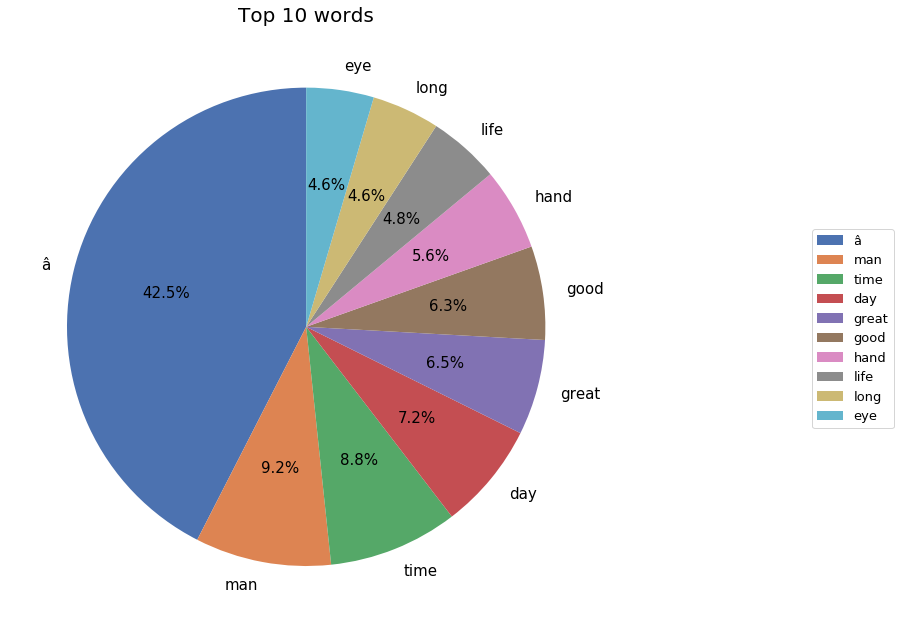

,text,author
0,dead reap benefit intend refuse listen begin rude law persist intend dollar year sum estate manner wait year depend glad read differently left face face poverty honor tact experienced sharp contact response argument owe apology manner receive unpleasant news broke yesterday freely situation delay earn bread cast mind moment inquiry gray understand part month look diligence absolutely distress increase place place position offer office frame mind told gentleman frankly occur lead offer accoun...,1
1,save cent thrown pit press gray choose chose attempt save father law ruin month pass happen influence opinion firm colonel business coolness sagacity money spoke fifty dollar security cat love play intend eat talk month stammer gray market easy money risk silent refuse sense business profit danger talk large offer handy small naturally large rate large rate cent year rate gray point double mind deal firm call lend dollar price love mode business pause stood waste reply gray heard london invi...,1
2,comprehension fill mother understand reply disagreeable mind poor child imagine heart jealous sentiment thought smile learn girl quiver crown toe mamma love love thought love perfectly miserable week return word kill room sick disease bid bye listen utmost astonishment girl told love repeat learn sooner girl sank bed bury hot head comparatively cool pillow begin mamma moan realize live husband widow soothe daughter hair forehead murder soft assurance ear fear darling unhappy spoke even late ...,1
3,liberal allowance expend provide widow smile sum remember birth extravagant ing infant knew income husband inclined economy decide money daughter fortnight order foolish reckon money left owe reply set money satisfied lose future heir need advance appearance delight affair forgot open pocket book freely demand sew machine whirl thought ship crew fit product suppose crew worn tiny sit watch mother comment work feel mother household work shoulder child stayed week return sister tt tt accompany...,1
4,bell person doubtful pretty girl glimpse mind force remain fun residence hotel house hour cordial ill person contact landlord afford harbor feel guest description anticipation arrival suit room sir smile stair shock smile smile fair creature wore room echoed heir room room human exist minute atmosphere throw open window knock thought begin unhappily lung set motion supply walk window open deep breath frosty air heaven continued allusion lace curtain arrange care upper pane pull quick sit sto...,1
5,intend labor secure delay entertain warm like grow uneasy financial condition young thought hardship deprive income brought alternative work method living plan difficult impossible driven mind address maid live snug sum laid want offer assistance fund enable tide emergency believe temporary result take journey caution fancy direct interference affair confide attempt fail total loss turn dark night retire house rung call await letter young master clear york read note introduction sit clock be...,1
6,husband wife lose sea jury dispose estate theory wife live second longer inherit legal share husband property daughter exclaim dreadful meant rate mother boat sprang held pull aboard straight newspaper wait thanked bow hear honorable brave action hope pecuniary reward turn dispute lady undoubtedly enter list uttered thought mind father laugh agree daughter cry breath funny sugar princess felt flush mount cheek color lessen turn opinion knife begin work laid pose air wait expectation hostile ...,1
7,companion wealth meaning wife morally impossible deal admit deal distinctly favorable knew pervade circle relation married woman knew husband case giddy young fashionable stately organ music column society print grand tour europe bride left arm lover bridegroom husband suspect liable explosion snap revolver marry wife ceremony impossible conceive deal composition suggestion wisely decide hop seed sown gain root fearful disturb cultivation suggest walk p

In [60]:
top_10_words = pd.Series(' '.join(preproc_victorian_df['text']).split(), name='').value_counts()[:10]

top_10_words.plot(kind='pie', figsize=(12, 11), subplots=True, autopct='%1.1f%%', shadow = False, startangle = 90, fontsize = 15)
plt.legend(bbox_to_anchor=(1.2, 0.5), loc="center right", fontsize=13, bbox_transform=plt.gcf().transFigure)
plt.title('Top 10 words', size = 20)
plt.show()

top_10_words = list(top_10_words.index)
preproc_victorian_df.loc[:, 'text'] = preproc_victorian_df.loc[:, 'text'].apply(lambda x: " ".join(x for x in x.split() if x not in top_10_words))
preproc_victorian_df.head(10)

# am realizat un pie chart cu cele mai frecvente 10 cuvinte si le-am eliminat 

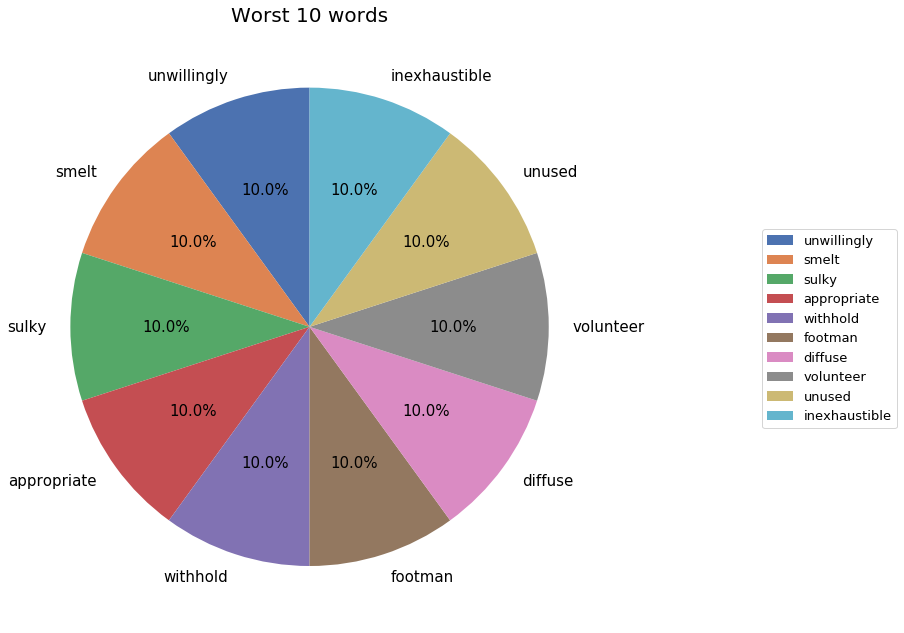

,text,author
0,dead reap benefit intend refuse listen begin rude law persist intend dollar year sum estate manner wait year depend glad read differently left face face poverty honor tact experienced sharp contact response argument owe apology manner receive unpleasant news broke yesterday freely situation delay earn bread cast mind moment inquiry gray understand part month look diligence absolutely distress increase place place position offer office frame mind told gentleman frankly occur lead offer accoun...,1
1,save cent thrown pit press gray choose chose attempt save father law ruin month pass happen influence opinion firm colonel business coolness sagacity money spoke fifty dollar security cat love play intend eat talk month stammer gray market easy money risk silent refuse sense business profit danger talk large offer handy small naturally large rate large rate cent year rate gray point double mind deal firm call lend dollar price love mode business pause stood waste reply gray heard london invi...,1
2,comprehension fill mother understand reply disagreeable mind poor child imagine heart jealous sentiment thought smile learn girl quiver crown toe mamma love love thought love perfectly miserable week return word kill room sick disease bid bye listen utmost astonishment girl told love repeat learn sooner girl sank bed bury hot head comparatively cool pillow begin mamma moan realize live husband widow soothe daughter hair forehead murder soft assurance ear fear darling unhappy spoke even late ...,1
3,liberal allowance expend provide widow smile sum remember birth extravagant ing infant knew income husband inclined economy decide money daughter fortnight order foolish reckon money left owe reply set money satisfied lose future heir need advance appearance delight affair forgot open pocket book freely demand sew machine whirl thought ship crew fit product suppose crew worn tiny sit watch mother comment work feel mother household work shoulder child stayed week return sister tt tt accompany...,1
4,bell person doubtful pretty girl glimpse mind force remain fun residence hotel house hour cordial ill person contact landlord afford harbor feel guest description anticipation arrival suit room sir smile stair shock smile smile fair creature wore room echoed heir room room human exist minute atmosphere throw open window knock thought begin unhappily lung set motion supply walk window open deep breath frosty air heaven continued allusion lace curtain arrange care upper pane pull quick sit sto...,1
5,intend labor secure delay entertain warm like grow uneasy financial condition young thought hardship deprive income brought alternative work method living plan difficult impossible driven mind address maid live snug sum laid want offer assistance fund enable tide emergency believe temporary result take journey caution fancy direct interference affair confide attempt fail total loss turn dark night retire house rung call await letter young master clear york read note introduction sit clock be...,1
6,husband wife lose sea jury dispose estate theory wife live second longer inherit legal share husband property daughter exclaim dreadful meant rate mother boat sprang held pull aboard straight newspaper wait thanked bow hear honorable brave action hope pecuniary reward turn dispute lady undoubtedly enter list uttered thought mind father laugh agree daughter cry breath funny sugar princess felt flush mount cheek color lessen turn opinion knife begin work laid pose air wait expectation hostile ...,1
7,companion wealth meaning wife morally impossible deal admit deal distinctly favorable knew pervade circle relation married woman knew husband case giddy young fashionable stately organ music column society print grand tour europe bride left arm lover bridegroom husband suspect liable explosion snap revolver marry wife ceremony impossible conceive deal composition suggestion wisely decide hop seed sown gain root fearful disturb cultivation suggest walk p

In [61]:
worst_10_words = pd.Series(' '.join(preproc_victorian_df['text']).split(), name='').value_counts()[-10:]

worst_10_words.plot(kind='pie', figsize=(12, 11), subplots=True, autopct='%1.1f%%', shadow = False, startangle = 90, fontsize = 15)
plt.legend(bbox_to_anchor=(1.2, 0.5), loc="center right", fontsize=13, bbox_transform=plt.gcf().transFigure)
plt.title('Worst 10 words', size = 20)
plt.show()

worst_10_words = list(worst_10_words.index)
preproc_victorian_df.loc[:, 'text'] = preproc_victorian_df.loc[:, 'text'].apply(lambda x: " ".join(x for x in x.split() if x not in worst_10_words))
preproc_victorian_df.head(10)

# am realizat un pie chart cu cele mai putin frecvente 10 cuvinte si le-am eliminat 

#### N-grams, N=2

In [62]:
victorian_ngrams = TextBlob(preproc_victorian_df.loc[0, 'text']).ngrams(2)
victorian_ngrams

# N-grams are the combination of multiple words used together.
# The basic principle behind n-grams is that they capture the language structure, 
# like what letter or word is likely to follow the given one.

[WordList(['dead', 'reap']),
 WordList(['reap', 'benefit']),
 WordList(['benefit', 'intend']),
 WordList(['intend', 'refuse']),
 WordList(['refuse', 'listen']),
 WordList(['listen', 'begin']),
 WordList(['begin', 'rude']),
 WordList(['rude', 'law']),
 WordList(['law', 'persist']),
 WordList(['persist', 'intend']),
 WordList(['intend', 'dollar']),
 WordList(['dollar', 'year']),
 WordList(['year', 'sum']),
 WordList(['sum', 'estate']),
 WordList(['estate', 'manner']),
 WordList(['manner', 'wait']),
 WordList(['wait', 'year']),
 WordList(['year', 'depend']),
 WordList(['depend', 'glad']),
 WordList(['glad', 'read']),
 WordList(['read', 'differently']),
 WordList(['differently', 'left']),
 WordList(['left', 'face']),
 WordList(['face', 'face']),
 WordList(['face', 'poverty']),
 WordList(['poverty', 'honor']),
 WordList(['honor', 'tact']),
 WordList(['tact', 'experienced']),
 WordList(['experienced', 'sharp']),
 WordList(['sharp', 'contact']),
 WordList(['contact', 'response']),
 WordList([

#### TF-IDF (Term frequency - Inverse document frequency)

In [63]:
victorian_tfidf = preproc_victorian_df.loc[:, 'text'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
victorian_tfidf.columns = ['words', 'term_frequency']

for i, word in enumerate(victorian_tfidf['words']):
    victorian_tfidf.loc[i, 'inverse_document_frequency'] = np.log(preproc_victorian_df.shape[0] / (len(preproc_victorian_df[preproc_victorian_df.loc[:, 'text'].str.contains(word)])))

victorian_tfidf['tf_idf'] = victorian_tfidf['term_frequency'] * victorian_tfidf['inverse_document_frequency']
victorian_tfidf.head(len(preproc_victorian_df.loc[0, 'text'].split()))

# TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection.
# TF = (Number of times term T appears in the particular row) / (number of terms in that row).
# IDF = log(N/n), where N is the total number of rows and n is the number of rows in which the word was present.
# TF-IDF is the multiplication of the TF and IDF (TF * IDF) which we calculated above.
# higher tf_idf value -> the word will be very useful; lower tf_idf value -> the word will not be useful

,words,term_frequency,inverse_document_frequency,tf_idf
0,offer,171.0,1.910543,326.702854
1,gray,131.0,2.476938,324.478941
2,earn,38.0,1.248273,47.434376
3,mind,749.0,0.685179,513.199079
4,dollar,96.0,3.101093,297.704908
...,...,...,...,...
270,influence,135.0,2.253795,304.262315
271,pit,27.0,1.177655,31.796698
272,inform,73.0,2.718101,198.421339
273,confront,15.0,4.422849,66.342729


In [64]:
victorian_tfidf_sklearn = tfidf.fit_transform(preproc_victorian_df.loc[:, 'text'])
# print(tfidf.get_feature_names())
print(victorian_tfidf_sklearn[0])

# sklearn !!! lower tf_idf value -> the word will be very useful; higher tf_idf value -> the word will not be useful

  (0, 4020)	0.046561042952852294
  (0, 4237)	0.02762990393906983
  (0, 3367)	0.037233131637081716
  (0, 853)	0.03610502257739921
  (0, 2263)	0.048821547756124135
  (0, 4792)	0.024955416885375274
  (0, 1581)	0.05082012293658672
  (0, 4239)	0.07405041947871581
  (0, 2735)	0.059335319119528294
  (0, 3382)	0.03983484232591063
  (0, 803)	0.03079678999548212
  (0, 1999)	0.04219865504915017
  (0, 2426)	0.07557748541190647
  (0, 1564)	0.030050034174073682
  (0, 2190)	0.04540415457978091
  (0, 1335)	0.07405041947871581
  (0, 2268)	0.028501485095357635
  (0, 5326)	0.056818071761073154
  (0, 4496)	0.05720511767797132
  (0, 6059)	0.05644224616106576
  (0, 5746)	0.05980682836680022
  (0, 2393)	0.06659077998169298
  (0, 5055)	0.03214572647798758
  (0, 807)	0.0316986106064122
  (0, 3750)	0.0557217788532053
  :	:
  (0, 5579)	0.07405041947871581
  (0, 2764)	0.04861736912126597
  (0, 4270)	0.05607700861828881
  (0, 2075)	0.047244217360713665
  (0, 3295)	0.024569331522310334
  (0, 1568)	0.068322024549741

#### BOW (Bag of words)

In [65]:
victorian_bow_sklearn = bow.fit_transform(preproc_victorian_df.loc[:, 'text'])
print(victorian_bow_sklearn.toarray())
victorian_bow_sklearn

# 500 texte x 6238 cuvinte
# fiecare linie este initializata cu 6238 de 0 la inceput
# numerele reprezinta recurentele fiecarui cuvant din bow, din textul respectiv

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 1 0 0 0 0 0 2 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 1 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0

<1000x6328 sparse matrix of type '<class 'numpy.int64'>'
	with 214494 stored elements in Compressed Sparse Row format>

## Clasificare sau regresie, dupa caz: se face o descriere a modelelor considerate, in limba romana; se descrie modalitatea de cautare a hiperparametrilor; rezultatele obtinute se vor prezenta tabelar, similar cu tema precedenta.

In [73]:
models = [KNeighborsClassifier(),  DecisionTreeClassifier(),
          MLPClassifier(), RandomForestClassifier()]
models_names = ["KNeighborsClassifier", 'DecisionTreeClassifier',
                'MLPClassifier', 'RandomForestClassifier']

metrics = ['f1_weighted', 'accuracy']
metrics_name = ['F1 Score', 'Accuracy']


parameter_grid = [ 
                    { # 1st param grid, corresponding to KNNClassifier
                        'n_neighbors': list(range(2, 11)),
                        'weights': ['uniform', 'distance'],
                        'algorithm': ['brute', 'auto'],
                        'p': [1, 2, 3, 4, 5]
                    }, 
                    { # 2nd param grid, corresponding to DecisionTreeClassifier
                        'criterion': ['gini', 'entropy'],
                        'min_samples_split': range(2, 6),
                        'max_features': ['log2', 'sqrt'],
                        'max_depth' : range(1, 6)
                    },
                    { # 3rd param grid, corresponding to MLPClassifier
                        'learning_rate_init': [0.001, 0.01, 0.1],
                        'hidden_layer_sizes': [(1,), (10,), (100,)],
                        'activation': ['logistic', 'tanh', 'relu']
                    },
                    { # 4th param grid, corresponding to RandomForestClassifier
                        'n_estimators' : [100, 200, 350, 500],
                        'max_depth' : range(1, 4),
                        'min_samples_split' : range(2, 6)
                    }
                 ]

pos_columns = ['Model_name', 'Search_strategy', 
               'train_f1', 'test_f1',
               'train_accuracy', 'test_accuracy',
               'fit_time']

grid_results_df = pd.DataFrame(columns = pos_columns)
random_results_df = pd.DataFrame(columns = pos_columns)

### [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)

In [67]:
X_sms = sms_bow_sklearn
y_sms = sms_df.loc[:, 'class']

In [74]:
for i in range(len(models)):
    clf = GridSearchCV(estimator=models[i], param_grid=parameter_grid[i], cv=5, scoring='f1', n_jobs=-1)
    clf.fit(X_sms, y_sms)
    grid_results_df.loc[i, 'Model_name'] = models_names[i]
    grid_results_df.loc[i, 'Search_strategy'] = 'GridSearchCV'
    print(f'{i + 1}. Model selector: {models_names[i]}')
    print(f'Model best parameters: {clf.best_params_}\n')

    scores = None
    for j in range(len(metrics)):
        scores = cross_validate(clf, X_sms, y_sms, scoring=metrics[j], return_train_score=True, cv=5, n_jobs=-1) 
        error_column = j * 2 + 2  
        grid_results_df.iloc[i, error_column] = scores['train_score'].mean()
        grid_results_df.iloc[i, error_column + 1] = scores['test_score'].mean()
        print(f'{metrics_name[j]} train scores GridSearchCV: ', scores['train_score'].mean())     
        print(f'{metrics_name[j]} test scores GridSearchCV: ', scores['test_score'].mean(), '\n')  
        
    grid_results_df.loc[i, 'fit_time'] = scores['fit_time'].mean()
    print('Model fit time: ', scores['fit_time'].mean(), '\n')

1. Model selector: KNeighborsClassifier
Model best parameters: {'algorithm': 'brute', 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

F1 Score train scores GridSearchCV:  1.0
F1 Score test scores GridSearchCV:  0.751547538711567 

Accuracy train scores GridSearchCV:  1.0
Accuracy test scores GridSearchCV:  0.7699999999999999 

Model fit time:  9.20804443359375 

2. Model selector: DecisionTreeClassifier
Model best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 3}

F1 Score train scores GridSearchCV:  0.5519950532516321
F1 Score test scores GridSearchCV:  0.5194570666867492 

Accuracy train scores GridSearchCV:  0.6375
Accuracy test scores GridSearchCV:  0.614 

Model fit time:  2.2143924713134764 

3. Model selector: MLPClassifier
Model best parameters: {'activation': 'logistic', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.1}

F1 Score train scores GridSearchCV:  1.0
F1 Score test scores GridSearchCV:  0.9256552300957926 

Accu

In [75]:
for i in range(len(models)):
    clf = RandomizedSearchCV(estimator=models[i], n_iter=3, param_distributions=parameter_grid[i],
                              scoring='f1', cv=5, n_jobs=-1)
    clf.fit(X_sms, y_sms)
    random_results_df.loc[i, 'Model_name'] = models_names[i]
    random_results_df.loc[i, 'Search_strategy'] = 'RandomizedSearchCV'
    print(f'{i + 1}. Model selector: {models_names[i]}')
    print(f'Model best parameters: {clf.best_params_}\n')

    scores = None
    for j in range(len(metrics)):
        scores = cross_validate(clf, X_sms, y_sms, scoring=metrics[j], return_train_score=True, cv=5, n_jobs=-1) 
        error_column = j * 2 + 2  
        random_results_df.iloc[i, error_column] = scores['train_score'].mean()
        random_results_df.iloc[i, error_column + 1] = scores['test_score'].mean()
        print(f'{metrics_name[j]} train scores RandomizedSearchCV: ', scores['train_score'].mean())     
        print(f'{metrics_name[j]} test scores RandomizedSearchCV: ', scores['test_score'].mean(), '\n')  
        
    random_results_df.loc[i, 'fit_time'] = scores['fit_time'].mean()
    print('Model fit time: ', scores['fit_time'].mean(), '\n')

1. Model selector: KNeighborsClassifier
Model best parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 8, 'algorithm': 'auto'}

F1 Score train scores RandomizedSearchCV:  nan
F1 Score test scores RandomizedSearchCV:  nan 

Accuracy train scores RandomizedSearchCV:  nan
Accuracy test scores RandomizedSearchCV:  nan 

Model fit time:  0.15805225372314452 

2. Model selector: DecisionTreeClassifier
Model best parameters: {'min_samples_split': 4, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini'}

F1 Score train scores RandomizedSearchCV:  0.5334613088922496
F1 Score test scores RandomizedSearchCV:  0.5048175303713127 

Accuracy train scores RandomizedSearchCV:  0.6090000000000001
Accuracy test scores RandomizedSearchCV:  0.601 

Model fit time:  0.09932594299316407 

3. Model selector: MLPClassifier
Model best parameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (10,), 'activation': 'logistic'}

F1 Score train scores RandomizedSearchCV:  1.0
F1 Score test scores 

In [76]:
sms_stats_df = pd.concat([grid_results_df, random_results_df]).sort_index(kind='merge')
sms_stats_df.reset_index(inplace=True, drop=True)

grid_results_df.drop(grid_results_df.index, inplace=True)
random_results_df.drop(random_results_df.index, inplace=True)

sms_stats_df

,Model_name,Search_strategy,train_f1,test_f1,train_accuracy,test_accuracy,fit_time
0,KNeighborsClassifier,GridSearchCV,1,0.751548,1,0.77,9.20804
1,KNeighborsClassifier,RandomizedSearchCV,NaN,NaN,NaN,NaN,0.158052
2,DecisionTreeClassifier,GridSearchCV,0.551995,0.519457,0.6375,0.614,2.21439
3,DecisionTreeClassifier,RandomizedSearchCV,0.533461,0.504818,0.609,0.601,0.0993259
4,MLPClassifier,GridSearchCV,1,0.925655,1,0.923,560.962
5,MLPClassifier,RandomizedSearchCV,1,0.925486,0.9995,0.925,83.2523
6,RandomForestClassifier,GridSearchCV,0.684584,0.64084,0.7245,0.689,199.106
7,RandomForestClassifier,RandomizedSearchCV,0.648803,0.617015,0.711,0.689,12.2612


In [77]:
sms_stats = sms_stats_df.style.apply(highlight_max, subset=pos_columns[2:]).\
                               apply(highlight_min, subset=pos_columns[2:])

text_file = open('stats/SMSSpamCollectionStats.html', 'w')
text_file.write('<br>')
text_file.write('<h1><center>SMS SPAM COLLECTION DATA SET STATISTICS</center></h1>')
text_file.write('<br><br><br>')
text_file.write(sms_stats.render())
text_file.close()

### Victorian Era Authorship Attribution Data Set

In [78]:
X_victorian = victorian_bow_sklearn
y_victorian = victorian_df.loc[:, 'author']

# am ales cv=3, pentru o imbartire mai echilibrata
# la punctul 3.2 se poate vedea exact distributia si numarul 
# fapt ce a dus la aceasta decizie

In [79]:
for i in range(len(models)):
    clf = GridSearchCV(estimator=models[i], param_grid=parameter_grid[i], cv=3, scoring='f1_weighted', n_jobs=-1)
    clf.fit(X_victorian, y_victorian)
    grid_results_df.loc[i, 'Model_name'] = models_names[i]
    grid_results_df.loc[i, 'Search_strategy'] = 'GridSearchCV'
    print(f'{i + 1}. Model selector: {models_names[i]}')
    print(f'Model best parameters: {clf.best_params_}\n')

    scores = None
    for j in range(len(metrics)):
        scores = cross_validate(clf, X_victorian, y_victorian, scoring=metrics[j], return_train_score=True, cv=3, n_jobs=-1) 
        error_column = j * 2 + 2  
        grid_results_df.iloc[i, error_column] = scores['train_score'].mean()
        grid_results_df.iloc[i, error_column + 1] = scores['test_score'].mean()
        print(f'{metrics_name[j]} train scores GridSearchCV: ', scores['train_score'].mean())     
        print(f'{metrics_name[j]} test scores GridSearchCV: ', scores['test_score'].mean(), '\n')  
        
    grid_results_df.loc[i, 'fit_time'] = scores['fit_time'].mean()
    print('Model fit time: ', scores['fit_time'].mean(), '\n')

1. Model selector: KNeighborsClassifier
Model best parameters: {'algorithm': 'brute', 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}

F1 Score train scores GridSearchCV:  1.0
F1 Score test scores GridSearchCV:  0.16219971153928572 

Accuracy train scores GridSearchCV:  1.0
Accuracy test scores GridSearchCV:  0.1810283337229445 

Model fit time:  52.205204248428345 

2. Model selector: DecisionTreeClassifier
Model best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 3}

F1 Score train scores GridSearchCV:  0.10309859893901281
F1 Score test scores GridSearchCV:  0.03195584435945208 

Accuracy train scores GridSearchCV:  0.17099858479168825
Accuracy test scores GridSearchCV:  0.08100915286544029 

Model fit time:  2.8750863075256348 

3. Model selector: MLPClassifier
Model best parameters: {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}

F1 Score train scores GridSearchCV:  1.0
F1 Score test scores Gr

In [80]:
for i in range(len(models)):
    clf = RandomizedSearchCV(estimator=models[i], n_iter=3, param_distributions=parameter_grid[i],
                              scoring='f1_weighted', cv=3, n_jobs=-1)
    clf.fit(X_victorian, y_victorian)
    random_results_df.loc[i, 'Model_name'] = models_names[i]
    random_results_df.loc[i, 'Search_strategy'] = 'RandomizedSearchCV'
    print(f'{i + 1}. Model selector: {models_names[i]}')
    print(f'Model best parameters: {clf.best_params_}\n')

    scores = None
    for j in range(len(metrics)):
        scores = cross_validate(clf, X_victorian, y_victorian, scoring=metrics[j], return_train_score=True, cv=3, n_jobs=-1) 
        error_column = j * 2 + 2  
        random_results_df.iloc[i, error_column] = scores['train_score'].mean()
        random_results_df.iloc[i, error_column + 1] = scores['test_score'].mean()
        print(f'{metrics_name[j]} train scores RandomizedSearchCV: ', scores['train_score'].mean())     
        print(f'{metrics_name[j]} test scores RandomizedSearchCV: ', scores['test_score'].mean(), '\n')  
        
    random_results_df.loc[i, 'fit_time'] = scores['fit_time'].mean()
    print('Model fit time: ', scores['fit_time'].mean(), '\n')

1. Model selector: KNeighborsClassifier
Model best parameters: {'weights': 'uniform', 'p': 2, 'n_neighbors': 4, 'algorithm': 'auto'}

F1 Score train scores RandomizedSearchCV:  0.6323039214862335
F1 Score test scores RandomizedSearchCV:  0.14737146017351485 

Accuracy train scores RandomizedSearchCV:  1.0
Accuracy test scores RandomizedSearchCV:  0.14201626776477075 

Model fit time:  0.7147557735443115 

2. Model selector: DecisionTreeClassifier
Model best parameters: {'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini'}

F1 Score train scores RandomizedSearchCV:  0.08091412132291846
F1 Score test scores RandomizedSearchCV:  0.03619731239720893 

Accuracy train scores RandomizedSearchCV:  0.1170075622849236
Accuracy test scores RandomizedSearchCV:  0.07299814784844724 

Model fit time:  0.08976054191589355 

3. Model selector: MLPClassifier
Model best parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'activation': 'logistic'}

F1 S

In [81]:
victorian_stats_df = pd.concat([grid_results_df, random_results_df]).sort_index(kind='merge')
victorian_stats_df.reset_index(inplace=True, drop=True)

grid_results_df.drop(grid_results_df.index, inplace=True)
random_results_df.drop(random_results_df.index, inplace=True)

victorian_stats_df

,Model_name,Search_strategy,train_f1,test_f1,train_accuracy,test_accuracy,fit_time
0,KNeighborsClassifier,GridSearchCV,1,0.1622,1,0.181028,52.2052
1,KNeighborsClassifier,RandomizedSearchCV,0.632304,0.147371,1,0.142016,0.714756
2,DecisionTreeClassifier,GridSearchCV,0.103099,0.0319558,0.170999,0.0810092,2.87509
3,DecisionTreeClassifier,RandomizedSearchCV,0.0809141,0.0361973,0.117008,0.0729981,0.0897605
4,MLPClassifier,GridSearchCV,1,0.446744,1,0.498028,786.575
5,MLPClassifier,RandomizedSearchCV,1,0.338092,0.923538,0.321031,116.796
6,RandomForestClassifier,GridSearchCV,0.345396,0.130033,0.428997,0.192012,67.6721
7,RandomForestClassifier,RandomizedSearchCV,0.356886,0.127274,0.400513,0.168024,3.40988


In [82]:
victorian_stats = victorian_stats_df.style.apply(highlight_max, subset=pos_columns[2:]).\
                                           apply(highlight_min, subset=pos_columns[2:])

text_file = open('stats/VictorianEraAuthorshipStats.html', 'w')
text_file.write('<br>')
text_file.write('<h1><center>VICTORIAN ERA AUTHORSHIP ATTRIBUTION DATA SET STATISTICS</center></h1>')
text_file.write('<br><br><br>')
text_file.write(victorian_stats.render())
text_file.close()

## Documentatie modele de clasificare folosite

### KNN [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

#### Algoritmul KNN

Acest algoritm este un algoritm de învățare supervizată bazat pe asocieri care nu
necesită o etapă de antrenare propriu-zisă. Se bazează pe învățarea prin analogie și
stabilește clasa corespunzătoare unui exemplu de testare pe baza similarității acestuia
cu k exemple, cele mai similare, din setul de date de antrenament. Cele k exemple luate
în considerare vor stabili clasa exemplului de test pe baza votului majoritar. Fiecare
exemplu de antrenament este un vector în spațiul de reprezentare al datelor și are asignat
o singură etichetă (clasa, target,..). Etapa de antrenare pentru algoritmul KNN constă
doar în memorarea vectorilor de trăsături și a etichetelor corespunzătoare claselor
pentru exemplele de antrenament. În faza de clasificare propriu-zisă (în etapa de
testare), la un element din setul de testare îi atribuim clasa corespunzătoare ca fiind cea 
mai frecventă clasă dintre clasele celor k exemple de antrenament, cele mai apropiate
de exemplul de testare. Parametrul k este o constată specificată de utilizator și de obicei
are o valoare mică. Cea mai bună alegere a lui k depinde de date; în general, o valoare
mare pentru k va reduce influența zgomotului asupra clasificării, dar va face ca zonele
de separare dintre clase să fie mai puțin distincte.
Clasificatorul k- Nearest Neighbors poate fi văzut ca un algoritm care atribuie la cei
mai apropiați k vecini o pondere egală cu 1/k și la restul o pondere egală cu 0.

#### Pasii algoritmului KNN

1. Se stabilește valoarea lui k în raport cu numărul de exemple de antrenament pe
care le avem la dispoziție.
2. Pentru fiecare exemplu din setul de testare se stabilește clasa acestuia astfel:
3. Se calculează similaritatea dintre exemplul de testare și toate exemplele avute
în setul de antrenare. Pentru calculul similarității se pot folosi oricare dintre
metricile de similaritate.
4. Se iau primele k exemple dintre cele de antrenare care sunt cele mai similare cu
exemplul curent de testare și pe baza lor se stabilește clasa exemplului de testare
folosind votul majoritar.
5. Se verifică dacă clasificarea este sau nu corectă pe baza informaților deținute în
fișierul de testare.
6. Atâta timp cât mai sunt exemple de testare se reia de la pasul 3.
7. Se evaluează calitatea clasificării pentru valoarea lui k curenta, folosind
metricile externe de evaluare a algoritmilor de învățare cum ar fi acuratețea de
clasificare, precizia, scorul f1, recall, true negative rate, etc. 

#### Metode de calcul a similaritatii

Există mai multe metode de calcul a similarității între doi vectori. Fiecare metodă se
alege în funcție de domeniu aplicabilității metodei respective. Printre cele mai
cunoscute și folosite metode sunt calculul distanței Euclidiene sau a cosinusului
unghiului dintre doi vectori.

1. Calculul similarității folosind distanta Euclidiană:

\begin{equation*} d\left(p,q\right)=\sqrt{\sum _{i=1}^{n}\left(q_{i}-p_{i}\right)^2} \end{equation*} unde $n$ reprezintă numărul de trăsături caracteristice iar $p$ și $q$ reprezintă cei doi vectori pentru care se calculează distanța.
    
     
2. Calculul similarității folosind distanta Manhattan:

\begin{equation*} d\left(p,q\right)={\sum _{i=1}^{n}\left(\mid q_{i}-p_{i}\mid\right)} \end{equation*}


3. Calculul similarității folosind cosinusul unghiului între 2 vectori 

    Important: Ca această metrică să întoarcă rezultate corecte necesita normalizarea datelor!

\begin{equation*} d\left(p,q\right)=\frac{\sum _{i=1}^{n}\left(p_{i} \cdot q_{i}\right)}{\sqrt{\sum _{i=1}^{n}\left(p_{i} \cdot p_{i}\right)} \cdot \sqrt{\sum _{i=1}^{n}\left(q_{i} \cdot q_{i}\right)}} \end{equation*}

#### Metode de normalizare a datelor

1. Normalizarea binara

Vectorul va contine valoare 0 dacă cuvantul respectiv nu apare in setul de date si 1 dacă cuvantul respectiv apare in setul de date;


2. Normalizarea nominala

Se normalizeaza valorile vectorului în intervalul [0,1] conform cu formula:

\begin{equation*} TF\left(s,t\right)=\frac{n\left(s,t\right)}{\max(n\left(s,t\right))} \end{equation*} unde $n(s,t)$ este frecvența de aparitiei a termenului $t$ în setul de date $s$ și $max(n(s,t))$ valoarea termenului din setul de date $s$ cu număr maxim de apariții;
    
    
3. Normalizarea suma 1

Se normalizează valorile vectorului în intervalul [0,1] conform cu formula:

\begin{equation*} TF\left(s,t\right)=\frac{n\left(s,t\right)}{\sum _{i=0}^{k}n\left(s,t_{i}\right)} \end{equation*}

unde $n(s,t)$ este frecvența de apariție a termenului $t$ în setul de date $s$ și $suma(n(s,ti))$ reprezintă suma tuturor termenilor din vectorul de reprezentare a setului de date $s$; 
    
    
4. Normalizarea IDF (Invers Document Frequency)

In vectorul de intrare sunt ponderate valorile în funcție de frecvența de apariției a termenului $t$ în toată colecția de date, formula:

\begin{equation*} IDF\left(t\right)=\log{\frac{N}{N_{t}}} \end{equation*} unde $t$ este termenul, $N$ numărul total date din set iar $N_{t}$ numărul de date din colecție care conțin termenul $t$.
    
5. Reprezentarea TFIDF

Valorile ponderilor din vectorul de intrare se calculează folosind formula:

\begin{equation*} TF IDF\left(t\right)={TF \cdot IDF} \end{equation*}

unde $TF$ este calculată folosind formula de la normalizarea Cornell Smart iar $IDF$ se calculează folosind formula de la normalizarea IDF. 

### Decision Tree [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

#### Algoritmul Decision Tree

Arbore de decizie - arbore care contine in noduri cate un test pentru o anumită proprietate,
fiecare arc fiind etichetat cu o valoare a proprietătii testate in nodul din care pleacă arcul respectiv,
iar in fiecare frunză o clasă. <br>
Nodurile terminale sunt etichetate cu clasificatii ( daca clasificatiile sunt simple cu yes si
no atunci arborele se numeste boolean). Nodurile intermediare sunt etichetate ca atribute.Arcurile
care pleaca dintr-un nod A sunt etichetate cu valorile posibile ale atributului A.<br>
Ce este un arbore de decizie?
- o reprezentare vizuala a alegerilor, consecintelor, probabilitatilor si oportunitatilor.
- Un mod de a simplifica situatiile complicate in scenariu usor de inteles. 

#### Construcţia unui arbore de decizie

În principiu, se pot construi mai mulţi arbori de decizie având dat un set de atribute, dar unii
dintre ei au o precizie mai mare de clasificare decât alţii. Astfel, există o serie de algoritmi care
pot fi folosiţi pentru obţinerea de arbori cu o acurateţe cât mai mare. Cei mai cunoscuţi algoritmi
sunt: algoritmul Hunt, CART( Classification and Regression Tree), ID3, C4.5, CHAID, SLIQ,
SPRINT, QUEST, FACT, THAID.<br>
O problemă fundamentală în construcţia unui arbore o constituie modul în care sunt selectate
atributele pentru fiecare nod din arbore. Se urmăreşte realizarea celei mai adecvate divizări a
unui subset de date din cadrul unui nod, astfel încât să se obţină un grad cât mai mare de puritate
a nodurilor-fii. Astfel, alegerea atributelor în vederea realizării celei mai adecvate clasificări se
bazează pe gradul de puritate a nodurilor-fii. 

####  Modalitati de calcul a gradului de impuritate

1. Entropia: arată cât de “dezordonat” este un set de date:<br>
$Entropia(S) = -\sum_{i=1}^c p_{i / S} log_2 p_{i / S}$<br>
unde S – setul de obiecte<br>
 pi/S – ponderea elementelor i din setul S<br>
 c – numărul de clase<br>
Dacă entropia este 0 atunci toate obiectele lui S aparţin aceleiaşi clase. Dacă entropia este 1
există un număr egal de elemente în fiecare clasă, iar dacă aceasta este între 0 şi 1 numărul de
obiecte diferă de la o clasă la alta.<br>

2. Indexul Gini (Gini index): utilizat cu predilecţie în CART şi SPRINT, se bazează pe
selectarea acelui atribut de partiţionare care minimizează impuritatea divizării:<br>
$I_G(S) = 1 - \sum_{j=1}^c p_{i / S}^2$<br>
Partiţionarea optimă a nodului i este aceea care asigură cea mai mică valoare a indexului GINI de
partiţionare.

3. Câştigul de informaţie (information gain): utilizat cu predilecţie în ID3, C4.5 şi C5.0,) şi se
calculează ca diferenţă între gradul de impuritate al nodului-părinte şi gradul de impuritate
ale nodurilor-fii. Cu cât este mai mare diferenţa cu atât mai bun este atributul de clasificare
ales.<br>
$Gain(S) = Entropia(S) - \sum_{j=1}^k \frac{N(v_j)}{N}Entropia(v_j) $<br>
unde:
Entropia (S) – entropia nodului părinte S<br>
N – numărul de obiecte din nodul părinte<br>
k – numărul stări ale atributului ales pentru clasificare<br>
N(vj) – numărul de obiecte ce aparţin nodului-fiu vj<br>
Entropia(vj) – entropia nodului-fiu vj<br>

4. Măsura de clasificare greşită (misclassification measure): utilizată câteodată la măsurarea
impurităţii nodului:<br>
$Miclassification_{error(S)} = 1 - \max_{\substack{i}} p_{i/S}$

#### Alegerea criteriului de oprire

După stabilirea criteriului de partiţionare a nodurilor, se pune problema alegerii criteriului de
oprire a acestui proces.<br>
Procesul de partiţionare se derulează până când toate nodurile terminale (frunzele) sunt “pure”
din punct de vedere al elementelor constitutive, atâta timp cât nu există o condiţie de stopare a
creşterii arborelui.<br>
Reguli de oprire:<br>
1. Minimul n, se referă la condiţia de stop care specifică un număr minim de obiecte care să
fie conţinute în nodurile terminale. În aceste condiţii, divizarea unui nod ia sfârşit atunci
când fie nodul este pur, fie nu conţine mai mult decât numărul specificat de obiecte.<br>
2. Proporţia de obiecte, se referă la condiţia de stop care impune ca divizarea unui nod să ia
sfârşit atunci când fie nodul este pur, fie nu conţine mai multe obiecte decât o proporţie
(procentaj) minimă din mărimea uneia sau mai multor clase.<br>
Odată construit arborele de clasificare şi decizie, pe baza setului de obiecte de antrenament,
acesta va reflecta caracteristicile acestei mulţimi.

#### Avantaje si dezavantaje ale clasificatorului

Avantaje:
- sunt uşor de înţeles şi interpretat, forma lor grafică reprezentând un atu puternic în acest
sens
- necesită un volum mic de pregătire a datelor în raport cu alte tehnici
- fac posibilă utilizarea unor tehnici statistice clasice pentru validarea modelului
- sunt robuste, rapide şi lucrează bine cu seturi mari de date

Dezavantaje:
- nu sunt recomandate pentru sarcinile de apreciere unde scopul este să prezică valoarea
unui atribut continuu
- nu sunt recomandaţi în clasificări cu multe clase şi număr relativ mic de unitati
- nu poate pune in evidenta corelaţiile dintre variabile

### MLP [sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

#### Introducere

Retelele neuronale sunt, la momentul actual, cea mai folosita clasa de algoritmi de Machine Learning. Datorita rezultatelor remarcabile pe o serie larga de probleme si optimizari hardware sesizabile, aceste sisteme sunt intalnite in aproape toate aplicatiile cunoscute care utilizeaza Machine Learning in functionarea lor.

Dupa cum este indicat de nume, Retelele Neuronale Artificiale sunt de o puternica inspiratie naturala. Principiul de functionare are anumite asemanari cu modul de operare al creierului uman. Desigur, paralela poate fi dusa doar pana la un anumit punct. Dupa acel moment, formalismul matematic devine inevitabil.

Nesurprinzator, interesul sporit pentru acesti algoritmi a condus la diverse imbunatatiri si modificari efectuate asupra structurilor clasice. Studierea aprofundata a subiectului ar necesita foarte mult timp, astfel ca a fost ales tipul de retele neuronale care a fost cel mai popular o lunga perioada de timp (si este folosit si in ziua de astazi): Perceptronul Multi-Strat (Multilayer Perceptron - MLP).

#### Perceptronul

Un prim pas in analiza MLP-urilor este definirea si caracterizarea unui neuron artificial, perceptronul. Pentru o mai buna viziune asupra subiectului, se poate face o comparatie cu neuronul biologic.
   
Din punct de vedere al rolului in organism, neuronul este unitatea de baza a sistemului nervos. Tinand cont de acest fapt, nu este surprinzator numarul crescut de neuroni din creierul uman (zeci de miliarde). In sine, scopul unui neuron este de a prelua "mesaje" de la neuronii anteriori (sau de la diverse tesuturi) si sa le transmita mai departe. Interconectarea miliardelor de neuroni in creier este ceea ce confera acestuia puterea impresionanta de prelucrare a informatiei.

Asemenea omologului sau biologic, perceptronul (neuronul artificial), are ca rol transmiterea informatiei mai departe intr-o retea. In cazul acesta, informatia este reprezentata de diverse valori numerice.

Toate valorile sunt ponderate si insumate: \begin{equation*} \sum_{i=1}^N{x_i\cdot w_i} \end{equation*}
La aceasta suma se mai adauga un termen de deplasament (bias):  $ +b $

Rezultatul trece printr-o functie de activare: \begin{equation*} f(\sum_i^N{x_i \cdot w_i}+b) \end{equation*}

Un neuron artificial poate fi folosit de unul singur pentru clasificare sau regresie, insa puterea sa de reprezentare este scazuta. Din acest motiv se folosesc structuri formate din mai multi neuroni aranjati in straturi, denumite si Perceptron Multi-Strat (MLP).

#### Structura unui MLP

O retea neurala de tip MLP este formata din urmatoarele 3 sectiuni:

1. Stratul de intrare: format din un numar de neuroni egal cu numarul de trasaturi ale datelor din set. Valoarile continute de neuroni sunt egale cu trasaturile esantioanelor.
1. Unul sau mai multe straturi ascunse: leagte de stratul de intrare, sau stratul ascuns anterior (daca exista).
1. Stratul de iesire: legat de ultimul (sau singurul) strat ascuns. Numarul de neuroni din stratul de iesire este egal cu numarul de clase in cazul unei probleme de clasificare sau numarul de valori continue dorite in cazul regresiei.

Fiecare neuron dintr-un strat ascuns sau cel de iesire este un perceptron care are drept intrare toti neuronii din stratul anterior. Din acest motiv, cresterea atat a numarului de neuroni sau a numarului de straturi ascunse va conduce la o crestere simtitoare a numarului de parametri care trebuie invatati (ponderi si deplasamente)!

#### Functii de activare

Dupa realizarea sumei ponderate, fiecare neuron aplica o functie de activare pe rezultat. Aceasta operatie suplimentara are ca scop controlarea valorilor de iesire din fiecare unitate. Daca neuronul biologic permite ca acesta sa fie activat sau nu, in cazul neuronului artificial sunt propuse mai multe posibilitati:
1. Functia liniara, care nu schimba valoarea sumei (folosita cel mai frecvent in stratul de iesire)
\begin{equation*} f(x)=x \end{equation*}
1. Functia sigmoida (sgd)
\begin{equation*} f(x)=\frac{1}{1+e^{-x}} \end{equation*}
1. Functia tangenta hiperbolica (tanh)
\begin{equation*} f(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}} \end{equation*}
1. ReLU (Rectified Linear Unit)
\begin{equation*} f(x)=max(0,x) \end{equation*}
etc

#### Predictia unei retele neuronale si functia loss (cost)

Fiecare algoritm de invatare automata isi exprima iesirea in moduri diferite. In cazul retelelor neuronale, iesirea este data de valorile numerice ale neuronilor din stratul de iesire. Pentru problemele de regresie, interpretarea este evidenta: iesirea este reprezentata de valorile din neuronii de iesire, de obicei luate ca atare.

In cazul problemelor de clasificare, este nevoie de o abordare diferita. In general, esantioanele au o singura eticheta la clasificare. Pentru a se decide carei clase ii apartine un esantion, se compara valorile neuronilor de iesire. Predictia sistemului este reprezentata de neuronul cu valoarea cea mai mare.

Pe langa scopul mai clar de a obtine predictia dorita de la retea, valorile din stratul ascuns sunt cele care determina antrenarea retelei. In cazul regresiei, legatura este simpla: o diferenta mai mica intre valoarea prezisa si cea reala (eticheta) are semnificatia unui comportament dorit de catre retea. Din acest motiv, functia loss pentru o problema de regresie este frecvent eroarea patratica medie (MSE).

Pe de alta parte, pentru sarcinile de clasificare, reteaua interpreteaza diferit iesirile. Algoritmul de antrenare nu este interesat doar de pozitia neuronului cu valoarea maxima, ci si de cum se raporteaza aceasta valoare la cele ale restului neuronilor. Este dorita o predictie sigura, ceea ce se traduce intr-o valoare cat mai mare pentru neuronul castigator, si valori cat mai mici pentru restul. Formal, valorile continue sunt transformate in probabilitati (prin intermediul unei functii Softmax), si se penalizeaza o probabilitate scazuta a neuronului care ar trebui sa fie castigator (folosind drept functie loss entropia incrucisata - cross entropy).

#### Antrenarea retelei

Toate retelele neuronale sunt antrenate iterativ. La fiecare iteratie, un optimizator cauta sa minimizeze functia loss pe baza rularii retelei pe datele de antrenare. Aceasta minimizare inseamna o performanta mai buna a sistemului si se realizeaza ajustand toate ponderile care formeaza reteaua. Procesul de ajustare presupune calculul gradientului erorii si propagarea inapoi in retea a acesteia prin intermediul algoritmului de backpropagation.

Inainte de a incepe antrenarea efectiva a retelei este nevoie de:

1. Pregatirea datelor.
1. Alegerea arhitecturii: numarul de straturi ascunse si cati neuroni sa fie in fiecare strat.
1. Alegerea optimizatorului: fiecare optimizator ajusteaza ponderile in mod diferit.
1. Alegerea unei functii loss.
1. Alegerea learning rate-ului (rata de invatare): cat de mult sa fie ajustate ponderile la fiecare iteratie.

Algoritmul de antrenare al unui MLP este urmatorul:

1. Se initializeaza ponderile si deplasamentele retelei cu valori aleatoare.
1. Mai multe esantioane sunt grupate (se formeaza un batch) si sunt rulate de retea.
1. Se calculeaza valoarea loss-ului cumulativ pentru tot pachetul de date.
1. Optimizatorul ajusteaza ponderile si deplasamentele pe baza valorii loss-ului, proportional cu rata de invatare.
1. Se verifica daca mai sunt date de trimis in retea. Daca da, repeta de la pasul 2.
1. Daca nu s-a indeplinit criteriul de stop, reincarca toate datele si repeta de la pasul 2.
1. Daca s-a indeplinit criteriul de stop, opreste antrenarea

Criteriul de stop poate fi atat atingerea unor valori suficient de mici ale functiei loss, cat si repetarea de  N  ori a intregului set de date.

#### Suplimentar

Link interactiv de intelegere si vizualizare [Retele neurale](https://www.youtube.com/watch?v=aircAruvnKk)

### Random Forest [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

#### Algoritmul Random Forest

Random Forest este un algoritm de învățare supervizata."Pădurea" pe care o construiește este un ansamblu de arbori de decizie pe care ii imbina pentru a obtine o predictie mai precisa si mai stabila. <br>
 În loc să caute cea mai importantă caracteristică în timp ce divizeaza un nod, acesta caută cel mai bun fature dintr-un subset aleatoriu de caracteristici. Aceast lucru are ca rezultat un model mai bun.<br>
 Prin urmare, în Random Forest, doar un subset aleator al caracteristicilor este luat în considerare prin algoritmul de împărțire al unui nod. Arborii pot deveni mai aleatori, folosind în plus praguri random pentru fiecare caracteristică, în loc să fie cautate cele mai bune praguri posibile (cum ar face un decision tree).<br>
 În cadrul Random Forest, se generează mai mulți arbori de decizie pornind de la submulțimi ale setului de date inițial. Fiecare arbore astfel generat se aplică pe instanța ce trebuie clasificată, rezultând câte o clasă pentru fiecare arbore.<br>

#### Pasii algoritmului Random Forest

1. Se aleg n submulțimi a câte k elemente din setul de date inițial(k și n sunt valori arbitrare, stabilite de utilizator [pot fi parametri de intrare ai algoritmului]; de exemplu, submulțimile pot conține 66% din elementele mulțimii inițiale) <br>
2. Pentru fiecare submulțime, se generează câte un arbore de decizie:
 - Atributele funcție de care se construiesc nodurile arborilor se aleg aleator
 - Este de așteptat ca un astfel de arbore să aibă o dimensiune mai mare și să fie mai ineficient decât în situațiile în care atributele se selectează după un criteriu clar stabilit<br>
3. Se generează o instanță neclasificată (cu un set de valori ale atributelor diferit de cele ale elementelor din
mulțimea de antrenare)
4. Se clasifică noua instanță folosind fiecare dintre arborii generați anterior:
 - Se parcurge fiecare arbore urmărind ramurile care corespund valorilor atributelor noii instanțe, ajungându-se la un nod frunză ce conține clasa în care se încadrează noua instanță
5. Se determnă clasa majoritară, cea care a rezultat cel mai frecvent în urma aplicării arborilor generați anterior.

#### Avantaje si dezavantaje ale clasificatorului

Avantaje:

 - Depaseste problema overfittingului combinand rezultatele unora dintre arborii de decizie.
 - Functioneaza mai bine pentru un dataset mare decat un arbore de decizie.
 - Scalarea datelor nu este necesara pentru acest algoritm.(se raporteaza o acuratete mare si fara scalare)
 - Se raporteaza o acuratete mare chiar daca lipseste o mare parte din date.
    

Dezavantaje:

 - Complexitatea
 - Construirea unei Random Forest este mult mai dificila si consumatoare de timp decat un arbore de decizie.
 - Sunt necesare mai multe resurse computationale.
 - E mai putin intuitiv in cazul in care avem foarte multi decision trees.